In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime
import math
import uproot
import ROOT
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import scipy.integrate as intg 
from scipy.stats import norm
from numpy.random import normal
import sipm.recon.WaveformAnalyzer as wfa
import sipm.recon.WaveformDataset as wfd
import sipm.util.functions as func
from datetime import datetime

plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Welcome to JupyROOT 6.26/08


## Functions defined here

In [2]:
def load_data(file_list, channel_list, volt):
    df_ch = {}
    dt = 0
    for ch in channel_list:
        df_ch[ch] = []
        for f in file_list:
            df = pd.read_hdf(f, key=f'{volt}/{ch}')
            df_ch[ch].append(df)
            if ch==-1:
                dt = datetime(*np.array(df['start_datetime'][:6]).astype(int))
            df = None
        df_ch[ch] = pd.concat(df_ch[ch]).sort_index()
        if ch!=-1:
            df_ch[ch].rename(columns=lambda x: x+f'_{ch}',inplace=True)            
    df_ch = pd.concat(list(df_ch.values()),axis=1)
    return df_ch, dt

def convert_to_pe(df_data,df_pe_scale,channels):
    pe_ch = df_data[[f'integral_9p60us_{ch}' for ch in range(8)]]
    pe_ch.columns = np.arange(8)
    pe_ch = pe_ch/df_pe_scale
    df_pe = pe_ch.iloc[:,channels].sum(axis=1)
    df_pe.name = 'pe_' + ''.join([str(c) for c in channels])
    pe_ch = None
    return df_pe

def get_bsl_filt(df_data,channels,rms_thre_ch):
    df_bsl_filt = {}
    for ch in channels:
        df_bsl_filt[f'bsl_filt_{ch}'] = df_data[f'baseline_rms_{ch}']<rms_thre_ch[ch]
        # print(df_bsl_filt[f'bsl_filt_{ch}'].sum())
    df_bsl_filt = pd.DataFrame(df_bsl_filt)
    df_bsl_filt['bsl_filt'] =  df_bsl_filt[[f'bsl_filt_{ch}' for ch in channels]].all(axis=1)
    return df_bsl_filt

def get_bsl_rms_hist(df_data,channels,bins,range):
    hist_ch = {}
    for ch in channels:
        hist_ch[ch] = np.histogram(df_data[f'baseline_rms_{ch}'], bins=bins, range=range)
    return hist_ch

def get_bsl_mean_hist(df_data,channels,bsl_filt,bins,range):
    hist_ch = {}
    for ch in channels:
        if bsl_filt:
            hist_ch[ch] = np.histogram(df_data.loc[df_data[f'bsl_filt_{ch}'],f'baseline_mean_{ch}'], bins=bins, range=range)
        else:
            hist_ch[ch] = np.histogram(df_data[f'baseline_mean_{ch}'], bins=bins, range=range)
    return hist_ch

def get_sat_filt(df_data,channels,sat_list):
    df_sat_filt = {}
    for ch in channels:
        df_sat_filt[f'sat_filt_{ch}'] = df_data[f'amplitude_{ch}']<sat_list[ch]
    df_sat_filt = pd.DataFrame(df_sat_filt)
    df_sat_filt['sat_filt'] =  df_sat_filt[[f'sat_filt_{ch}' for ch in range(8)]].all(axis=1)
    return df_sat_filt

def get_fp_filt(df_data,channel_groups,fp_dict,length):
    df_fp_filt = {}
    for g in channel_groups:
        df_fp_filt[f'fp_filt_{g}'] = df_data[f'fprompt_{length}_{g}']>fp_dict[g]
    df_fp_filt = pd.DataFrame(df_fp_filt)
    df_fp_filt['fp_filt'] =  df_fp_filt[[f'fp_filt_{g}' for g in channel_groups]].all(axis=1)
    return df_fp_filt

def get_fp_hist2d(df_data,channel_groups,length,bins_xy,range_xy,log_scale):
    hist2d_g = {}
    for g in channel_groups:
        filt = df_data['bsl_filt']
        hist2d_g[g] = list(np.histogram2d(
            df_data[f'pe_{g}'][filt], 
            df_data[f'fprompt_{length}_{g}'][filt], 
            bins=bins_xy, range=range_xy
        ))
        temp = hist2d_g[g][0].T
        hist2d_g[g][0], hist2d_g[g][1] = np.meshgrid(
            hist2d_g[g][1], hist2d_g[g][2]
        )
        if log_scale:
            hist2d_g[g][2] = np.log10(temp)
        else:
            hist2d_g[g][2] = temp
    return hist2d_g

def get_fs_nofs_hist2d(df_data,bsl_filt,fp_filt,sat_filt,bins_xy,range_xy,log_scale):
    filt = np.ones(df_data.shape[0])
    if bsl_filt:
        filt = filt & df_data['bsl_filt']
    if fp_filt:
        filt = filt & df_data['fp_filt_01234567']
    if sat_filt:
        filt = filt & df_data['sat_filt']
    hist2d = list(np.histogram2d(
        df_data['nofs_pe'][filt], 
        df_data['fs_pe'][filt], 
        bins=bins_xy, range=range_xy
    ))
    temp = hist2d[0].T
    hist2d[0], hist2d[1] = np.meshgrid(
        hist2d[1], hist2d[2]
    )
    if log_scale:
        hist2d[2] = np.log10(temp)
    else:
        hist2d[2] = temp
    return hist2d

## Read calibration file and get PE scale

In [3]:
calib = {}
pe_scale = {}
voltages = [92,94,96,98,100]
for volt in voltages:
    calib[volt] = pd.read_hdf('data/calibration_liq6_2023-12-13.h5', key=f'{volt}V')
    pe_scale[volt] = calib[volt]['Qavg']/(1-calib[volt]['DiCT'])

## G4DS simulation (Compton scattering + UV photon transport)

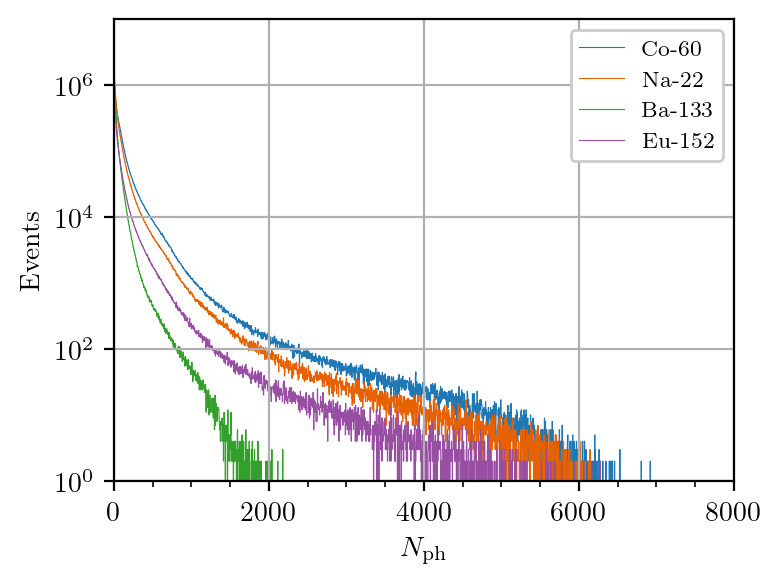

In [4]:
src = {'Co-60':'co60','Na-22':'na22','Ba-133':'ba133','Eu-152':'eu152'}
hist_sim = {}
for S,s in src.items():
    rtf = uproot.open(f'data/pe_hist/no_reflection/pu_lar_{s}_hist.root')
    hist_sim[S] = rtf['nph_nofs_1247'].to_numpy()
    plt.stairs(hist_sim[S][0],hist_sim[S][1],linewidth=0.4,label=S)
plt.grid()
plt.minorticks_on()
plt.yscale('log')
plt.xlabel(r'$N_{\rm ph}$')
plt.ylabel('Events')
plt.legend(loc='upper right')

## Detector response model
The number of PE follows the distribution
$$N_{\rm PE} \sim \mathcal{N}(\mu=N_{\rm ph}\times\varepsilon_p S_y/S_y^0, \sigma=\sqrt{F\mu}),$$
where $N_{\rm ph}$ is the number of photons arriving at the SiPMs (from G4DS), $\varepsilon_p$ is the SiPMs' photo-detection efficiency (PDE), $S_y^0$ is the LAr scintillation yield used in G4DS (probably $1ph/19.5eV=51.3ph/keV$), $S_y$ is the true scintillation yield ($\approx 40ph/keV$ for pure LAr), and $F>1$ is the Fano factor of the SiPMs due to correlated avalanches.

In [5]:
class DetectorSmearing():
    def __init__(self, fano, hist_in):
        self.hist_in_bin = hist_in[1]
        self.hist_in_width = self.hist_in_bin[1]-self.hist_in_bin[0]
        self.hist_in_count = hist_in[0]/np.sum(hist_in[0])/self.hist_in_width # normalized
        self.fano = fano

    def response_matrix(self, pe_in, pe_out, pde):
        pe_det = pde*pe_in
        smear2 = 0
        return norm.pdf(pe_out, loc=pe_det, scale=np.sqrt(self.fano*pe_det + smear2**2*pe_det**2))

    def get_spectrum(self, bins, n, pde):
        self.hist_out_bin = bins
        bin_cen_in = (self.hist_in_bin[1:]+self.hist_in_bin[:-1])/2
        bin_cen_out = (self.hist_out_bin[1:]+self.hist_out_bin[:-1])/2
        pe_out_mesh, pe_in_mesh = np.meshgrid(bin_cen_out, bin_cen_in)
        self.hist_out_count = self.hist_in_count @ self.response_matrix(pe_in_mesh, pe_out_mesh, pde)
        return n*self.hist_out_count, self.hist_out_bin
        
    def fit_to_data(self, data, sigma, x0, fit_range):
        def residual(x, *args, **kwargs):
            n, pde = x[0], x[1]
            data_y, data_bin = args[0], args[1]
            bincen = (data_bin[1:] + data_bin[:-1])/2
            ans = (data_y-self.get_spectrum(data_bin, n, pde)[0])
            sigma[sigma==0] = 1
            ans = ans/sigma
            mask = (bincen<fit_range[1]) & (bincen>fit_range[0])
            return ans[mask]
        res = least_squares(residual,x0=x0,args=data,bounds=(0,np.inf))
        cov = np.linalg.inv(res.jac.T@res.jac)
        return res.x, cov
        

## Change channel mapping in calibration file from liq5

In [6]:
# store_in = pd.HDFStore('data/calibration_liq5_2023-12-13.h5')
# keys = store_in.keys()
# store_out = pd.HDFStore('data/calibration_liq6_2023-12-13.h5')
# for k in keys:
#     df = store_in.get(k)
#     df['channel'] = [0,5,6,3,4,1,2,7]
#     df = df.sort_values('channel')
#     df.index = df['channel'].to_numpy()
#     df['max_amp'] = [1490]*4+[1440]*4
#     store_out.put(k,df)
# store_out.close()

In [7]:
# store_new = pd.HDFStore('data/calibration_liq6_2023-12-13.h5')
# df = store_new.get('98V')
# print(df)
# store_new.close()

## Visualize waveforms from original binary files

In [8]:
# evid = np.arange(0, 10)
# # evid = [ 11  ,40 , 88, 115 ,134 ,138 ,141 ,146 ,153, 166]
# dset = wfd.WaveformDataset(
#     path='/scratch/gpfs/GALBIATI/data/sipm/xenon_doping/2024-03-06/2024-03-06_volt_98_light_scintillation_source_co60_xenon_2_cond_monitor/7/', 
#     pol=-1, 
#     channels=range(8))
# wfs = []
# for ch in np.arange(8):
#     wfs.append(dset.ch[ch].get_waveforms(ev=evid, ar_filter=False)[0])
# wfs = np.array(wfs)
# print(wfs.shape)
# for i in range(wfs.shape[1]):
#     plt.figure(i, figsize=(3, 3))
#     for ch in range(wfs.shape[0]):
#         plt.plot(dset.ch[ch].time, wfs[ch,i]+ch*50, label=f'Ch{ch}', linewidth=0.5)
#     plt.legend(loc='upper right', fontsize=5)
#     plt.xlabel(r'Time [$\mu s$]')
#     plt.ylabel(r'Voltage [A.U.]')
#     plt.minorticks_on()
#     plt.grid()
#     plt.xlim(0, 16)
#     plt.ylim(-60, 400)
#     plt.title(f'Event No. {evid[i]}')

# 1. Pure LAr All Sources 02/23

In [12]:
path = "/scratch/gpfs/as111/results/"
date = '2024-02-23'
files = [[],[],[],[],[]] # Co-60, Na-22, Ba-133, Eu-152, Backgrounds
files[0].extend(glob(f"{path}{date}/*cond_gamma_source_co60*scintillation_pulse_liq6.h5"))
files[1].extend(glob(f"{path}{date}/*source_na22*scintillation_pulse_liq6.h5"))
files[2].extend(glob(f"{path}{date}/*source_ba133*scintillation_pulse_liq6.h5"))
files[3].extend(glob(f"{path}{date}/*source_eu152*scintillation_pulse_liq6.h5"))
files[4].extend(glob(f"{path}{date}/*source_none*scintillation_pulse_liq6.h5"))
print(len(files[0]), files[0])
print(len(files[1]), files[1])
print(len(files[2]), files[2])
print(len(files[3]), files[3])
print(len(files[4]), files[4])

10 ['/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_co60_xenon_0_run3_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_co60_xenon_0_run4_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_co60_xenon_0_run1_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_co60_xenon_0_run2_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_co60_xenon_0_run6_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_co60_xenon_0_run5_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_co60_xenon_0_run0_scintillati

In [13]:
data = {}
channels = np.arange(-1,8)
volt = 98
cond = ['Co-60','Na-22','Ba-133','Eu-152','Backgrounds']
date_time = []
for i, c in enumerate(cond):
    data[c], dt = load_data(files[i],channels,volt)
    print(f'{c}: {data[c].shape[0]} events {dt}')
    date_time.append(dt) 
print('columns: ', list(data[cond[0]].columns))

Co-60: 503564 events 2024-02-23 11:23:28
Na-22: 502997 events 2024-02-23 12:27:52
Ba-133: 503143 events 2024-02-23 13:15:57
Eu-152: 503165 events 2024-02-23 14:40:01
Backgrounds: 251828 events 2024-02-23 16:04:28
columns:  ['start_datetime', 'end_datetime', 'duration_seconds', 'nch', 'nch_fs', 'nch_nofs', 'total_pe', 'fprompt_0p30us_01234567', 'fprompt_0p30us_0356', 'fprompt_0p30us_1247', 'baseline_mean_0', 'baseline_rms_0', 'integral_0p30us_0', 'integral_5p00us_0', 'integral_9p60us_0', 'fired_0', 'amplitude_0', 'peakpos_0', 'baseline_mean_1', 'baseline_rms_1', 'integral_0p30us_1', 'integral_5p00us_1', 'integral_9p60us_1', 'fired_1', 'amplitude_1', 'peakpos_1', 'baseline_mean_2', 'baseline_rms_2', 'integral_0p30us_2', 'integral_5p00us_2', 'integral_9p60us_2', 'fired_2', 'amplitude_2', 'peakpos_2', 'baseline_mean_3', 'baseline_rms_3', 'integral_0p30us_3', 'integral_5p00us_3', 'integral_9p60us_3', 'fired_3', 'amplitude_3', 'peakpos_3', 'baseline_mean_4', 'baseline_rms_4', 'integral_0p30u

In [14]:
channels_nofs = [1,2,4,7]
channels_fs = [0,3,5,6]
volt = 98
for i, c in enumerate(cond):
    df_nofs, df_fs = convert_to_pe(data[c],pe_scale[volt],channels_nofs), convert_to_pe(data[c],pe_scale[volt],channels_fs)
    data[c][df_nofs.name] = df_nofs
    df_nofs = None
    data[c][df_fs.name] = df_fs
    df_fs = None
    data[c]['pe_01234567'] = data[c]['total_pe']
    data[c]['fs_pe'] = data[c]['pe_0356']
    data[c]['nofs_pe'] = data[c]['pe_1247']
print('columns: ', list(data[cond[0]].columns))

columns:  ['start_datetime', 'end_datetime', 'duration_seconds', 'nch', 'nch_fs', 'nch_nofs', 'total_pe', 'fprompt_0p30us_01234567', 'fprompt_0p30us_0356', 'fprompt_0p30us_1247', 'baseline_mean_0', 'baseline_rms_0', 'integral_0p30us_0', 'integral_5p00us_0', 'integral_9p60us_0', 'fired_0', 'amplitude_0', 'peakpos_0', 'baseline_mean_1', 'baseline_rms_1', 'integral_0p30us_1', 'integral_5p00us_1', 'integral_9p60us_1', 'fired_1', 'amplitude_1', 'peakpos_1', 'baseline_mean_2', 'baseline_rms_2', 'integral_0p30us_2', 'integral_5p00us_2', 'integral_9p60us_2', 'fired_2', 'amplitude_2', 'peakpos_2', 'baseline_mean_3', 'baseline_rms_3', 'integral_0p30us_3', 'integral_5p00us_3', 'integral_9p60us_3', 'fired_3', 'amplitude_3', 'peakpos_3', 'baseline_mean_4', 'baseline_rms_4', 'integral_0p30us_4', 'integral_5p00us_4', 'integral_9p60us_4', 'fired_4', 'amplitude_4', 'peakpos_4', 'baseline_mean_5', 'baseline_rms_5', 'integral_0p30us_5', 'integral_5p00us_5', 'integral_9p60us_5', 'fired_5', 'amplitude_5', 

In [15]:
rms_threshold = [2.0,2.0,2.0,2.0,2.3,2.0,2.0,2.0]
for c in cond:
    df_bsl_filt = get_bsl_filt(data[c],np.arange(8),rms_threshold)
    data[c][df_bsl_filt.columns] = df_bsl_filt
    df_bsl_filt = None

In [16]:
# Initialize Fprompt container
fprompt = {}
positions = ['all','fs','nofs']
groups = ['01234567','0356','1247']
fp_thre = {'01234567':0.1,'0356':0.1,'1247':0.1}

In [17]:
# Produce fprompt 2D histograms
binsx = 500
range_minx = -10
range_maxx = 600
binsy = 500
range_miny = 0
range_maxy = 1

for c in cond:
    fprompt[c] = get_fp_hist2d(data[c],groups,'0p30us',bins_xy=[binsx,binsy],range_xy=[[range_minx,range_maxx],[range_miny,range_maxy]],log_scale=True)
    df_fp_filt = get_fp_filt(data[c],groups,fp_thre,'0p30us')
    data[c][df_fp_filt.columns] = df_fp_filt
    df_fp_filt = None

Text(0.5, 0.05, '$N_{\\rm PE}$')

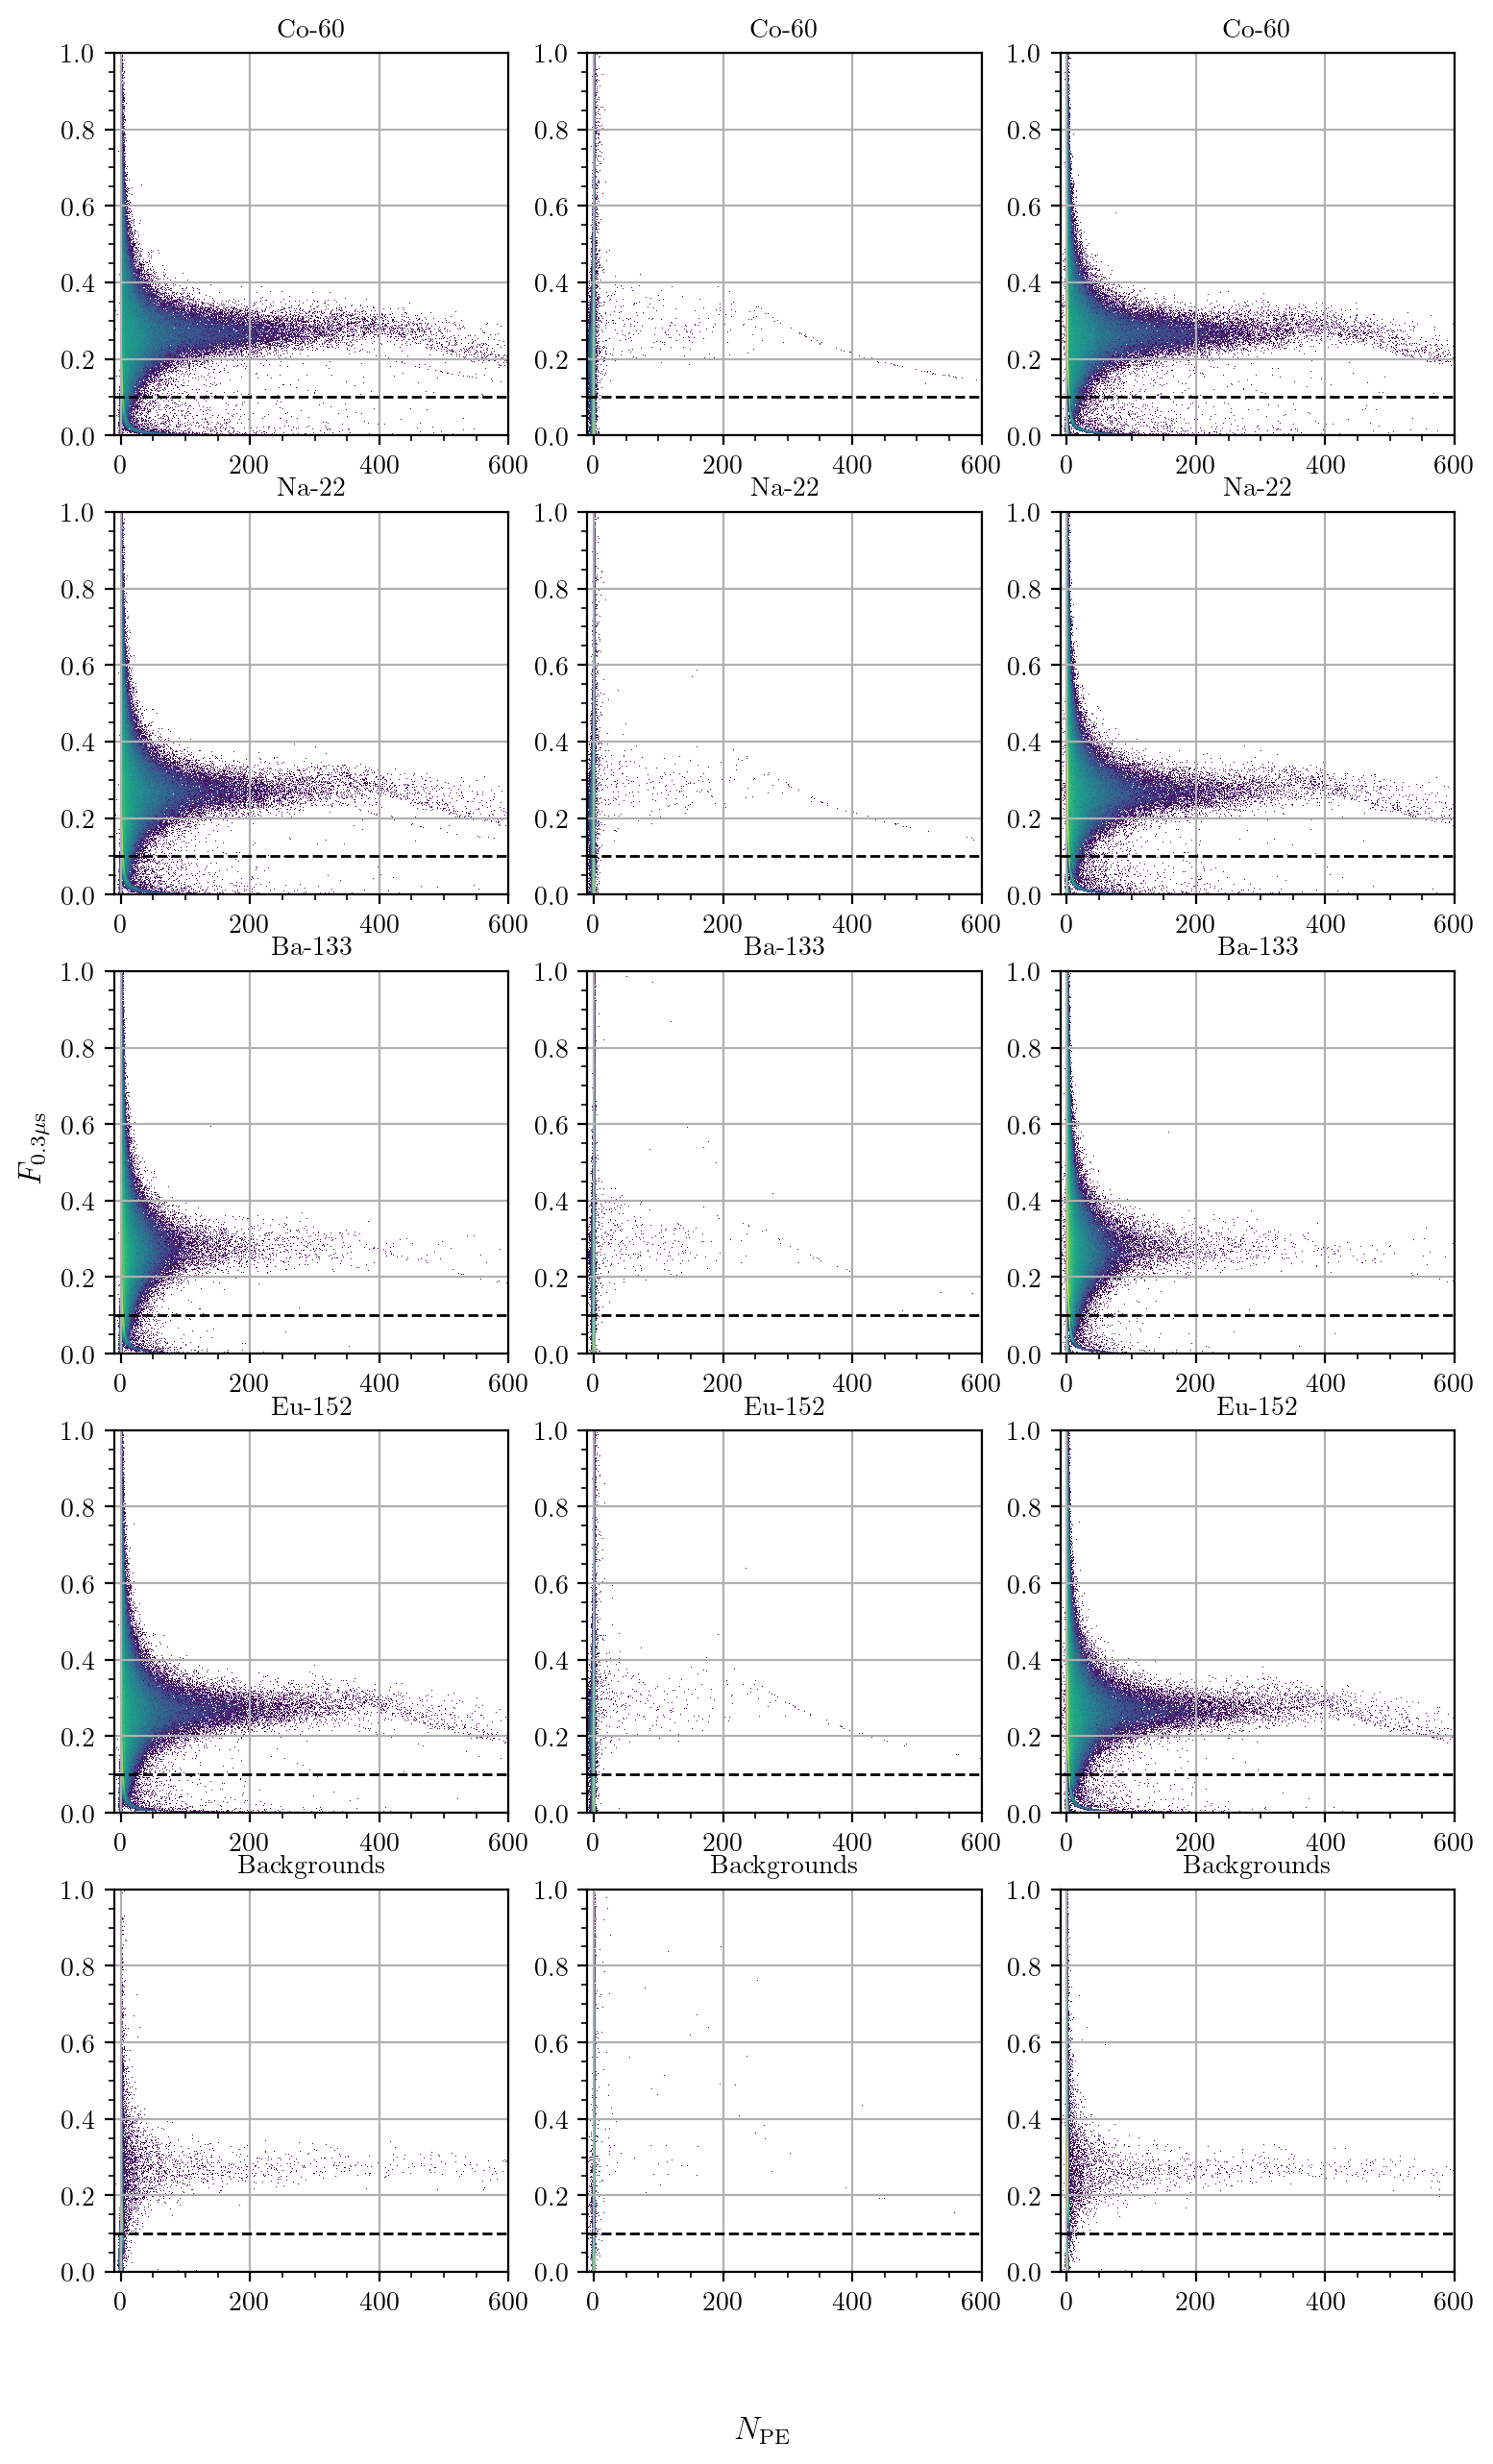

In [18]:
# Fprompt plots for all datasets
fig, axs = plt.subplots(len(cond), 3, sharex=False, sharey=False)
fig.tight_layout(h_pad=5, w_pad=3)
fig.set_size_inches(9, 3*len(cond))
for i,c in enumerate(cond):
    for j, (p,g) in enumerate(zip(positions,groups)):
        axs[i,j].pcolormesh(*fprompt[c][g])
        axs[i,j].plot([-10,range_maxx],[fp_thre[g]]*2,'k--',linewidth=1)
        axs[i,j].set_xlim(-10, range_maxx)
        axs[i,j].minorticks_on()
        axs[i,j].grid()
        axs[i,j].set_title(f'{c}')
fig.supylabel(r'$F_{\rm 0.3\mu s}$', x=0.07)
fig.supxlabel(r'$N_{\rm PE}$',y=0.05)

In [19]:
nbinsx = 500
range_minx = -50
range_maxx = 1000
nbinsy = 500
range_miny = -50
range_maxy = 500

fs_nofs_pe = {}
for c in cond:
    fs_nofs_pe[c] = {}
    bsl_filt = data[c]['bsl_filt']
    fs_nofs_pe[c]['counts'], fs_nofs_pe[c]['xbins'], fs_nofs_pe[c]['ybins'] = np.histogram2d(
        data[c]['nofs_pe'][bsl_filt & data[c]['fp_filt_01234567']], 
        data[c]['fs_pe'][bsl_filt & data[c]['fp_filt_01234567']], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    )
    fs_nofs_pe[c]['counts'] = fs_nofs_pe[c]['counts'].T
    fs_nofs_pe[c]['xbins'], fs_nofs_pe[c]['ybins'] = np.meshgrid(
        fs_nofs_pe[c]['xbins'], fs_nofs_pe[c]['ybins']
    )

Backgrounds to be scaled by 0.23076923076923078 in Co-60 data
Backgrounds to be scaled by 0.3076923076923077 in Na-22 data
Backgrounds to be scaled by 0.28205128205128205 in Ba-133 data
Backgrounds to be scaled by 0.2564102564102564 in Eu-152 data


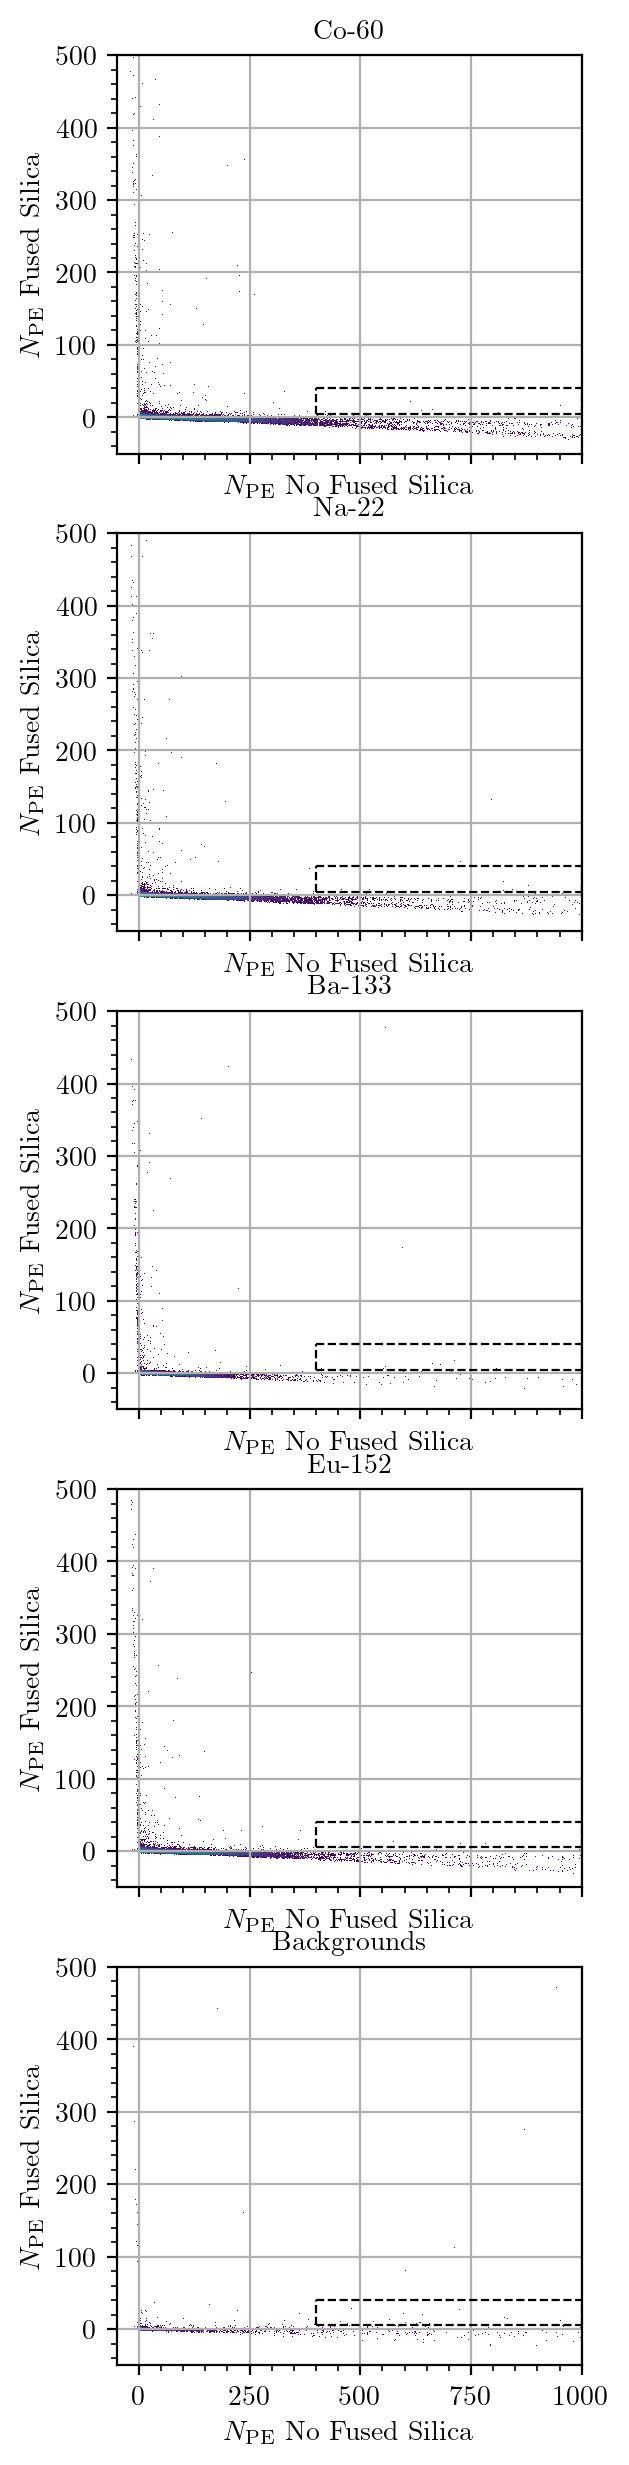

In [20]:
nrows = 5
fig, axs = plt.subplots(nrows, 1, sharex=True, sharey=True)
fig.set_size_inches(3, 3*nrows)
x1, y1, x2, y2 = 400, 5, 1000, 40
for i, c in enumerate(cond):
    axs[i].pcolormesh(
        fs_nofs_pe[c]['xbins'],
        fs_nofs_pe[c]['ybins'],
        np.log10(fs_nofs_pe[c]['counts'])
    )
    axs[i].minorticks_on()
    axs[i].grid()
    axs[i].set_title(f'{c}')
    axs[i].set_xlim(-50, 1000)
    axs[i].set_ylim(-50, 500)
    axs[i].set_xlabel(r'$N_{\rm PE}$ No Fused Silica')
    axs[i].set_ylabel(r'$N_{\rm PE}$ Fused Silica')
    axs[i].plot([x1,x1], [y1,y2], 'k--', linewidth=0.8)
    axs[i].plot([x2,x2], [y1,y2], 'k--', linewidth=0.8)
    axs[i].plot([x1,x2], [y1,y1], 'k--', linewidth=0.8)
    axs[i].plot([x1,x2], [y2,y2], 'k--', linewidth=0.8)

mask_x, mask_y = (fs_nofs_pe[c]['xbins'][0,1:]<x2)&(fs_nofs_pe[c]['xbins'][0,1:]>x1), (fs_nofs_pe[c]['ybins'][1:,0]<y2)&(fs_nofs_pe[c]['ybins'][1:,0]>y1)
bkg_scale = {}
for c in cond[:-1]:
    bkg_scale[c] = np.sum(fs_nofs_pe[c]['counts'][mask_y][:,mask_x])/np.sum(fs_nofs_pe['Backgrounds']['counts'][mask_y][:,mask_x])
    print(f'Backgrounds to be scaled by {bkg_scale[c]} in {c} data')

In [21]:
# Initialize container
spectra = {}
window = ['yes', 'no']
for c in cond:
    spectra[c] = {}
    for w in window:
        spectra[c][w] = {}

In [22]:
# Region above norm_bounds is background only. Use event count in this region to normalize spectrum.
for c in cond:
    for w in window:
        if w=='yes':
            range_min = -10
            range_max = 2000
            nbins = 4000
        elif w=='no':
            range_min = -10
            range_max = 2000
            nbins = 4000
        bsl_filt = data[c]['bsl_filt']
        spectra[c][w]['counts'], spectra[c][w]['bins'] = np.histogram(
            data[c]['nofs_pe'][bsl_filt & data[c]['fp_filt_01234567']] if w=='no' else data[c]['fs_pe'][bsl_filt & data[c]['fp_filt_01234567']], 
            bins=nbins, range=(range_min, range_max)
        )
        spectra[c][w]['errs'] = np.sqrt(spectra[c][w]['counts'])

Text(0.06, 0.5, 'Events')

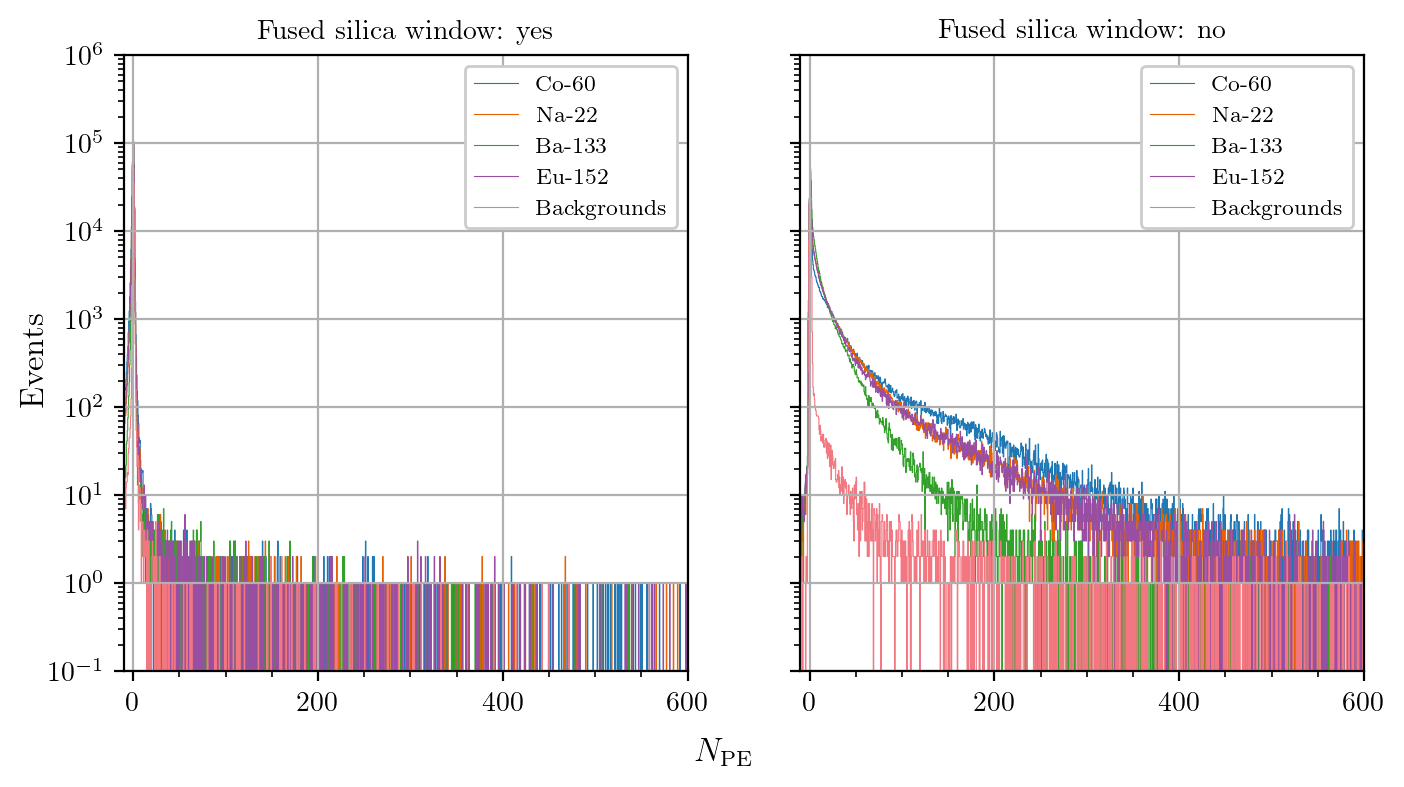

In [23]:
# Make plots for all datasets
# With source, without source, and background subtracted
fig, axs = plt.subplots(1, 2, sharex=False, sharey=True)
fig.set_size_inches(8, 4)
for j, w in enumerate(window):
    for i, c in enumerate(cond):
        c = cond[i]
        axs[j].stairs(
            spectra[c][w]['counts'], 
            spectra[c][w]['bins'], 
            label=f'{c}', color=f'C{i}', linewidth=0.4
        )
    axs[j].legend(loc='upper right')
    axs[j].set_ylim(1e-1, 1e6)
    axs[j].set_xlim(-10, 600)
    axs[j].set_yscale('log')
    axs[j].minorticks_on()
    axs[j].grid()
    axs[j].set_title(f'Fused silica window: {w}')
fig.supxlabel(r'$N_{\rm PE}$', y=-0.01)
fig.supylabel('Events', x=0.06)

In [24]:
for c in cond[:-1]:
    spectra[c][w]['counts'] = spectra[c][w]['counts'] - spectra['Backgrounds'][w]['counts']*bkg_scale[c]
    spectra[c][w]['errs'] = (spectra[c][w]['errs']**2 + (spectra['Backgrounds'][w]['errs']*bkg_scale[c])**2)**0.5

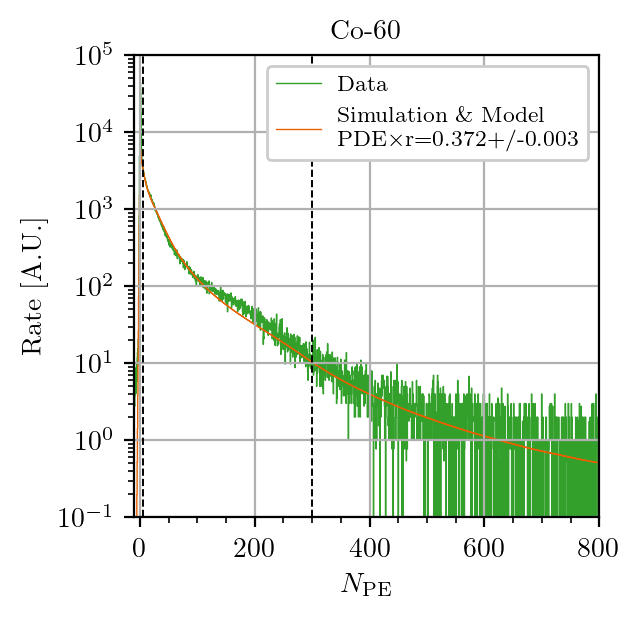

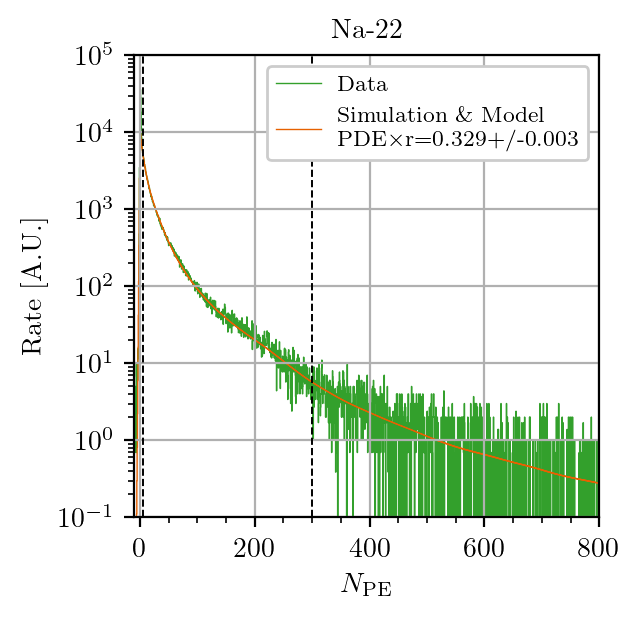

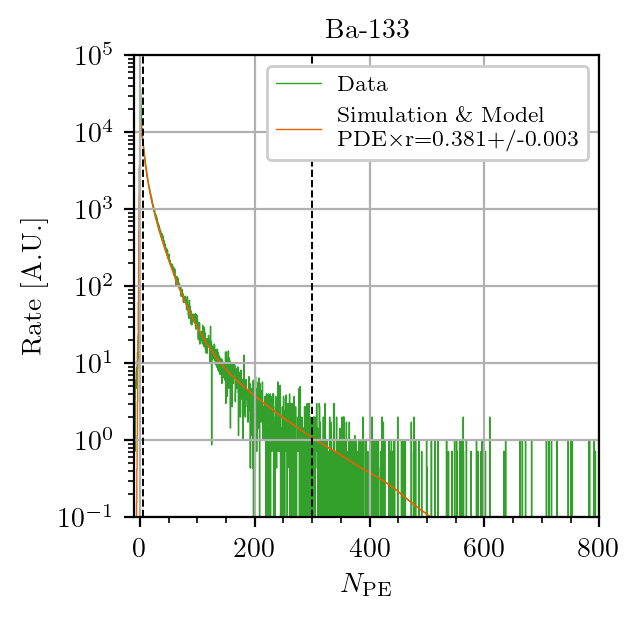

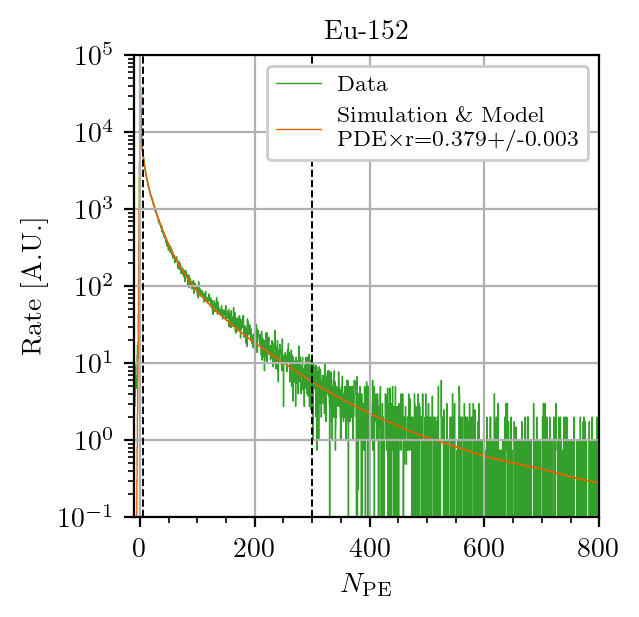

In [25]:
ly0 = {}
ly0_err = {}
for i,c in enumerate(cond[:-1]):
    plt.figure(i,figsize=(3,3))
    fit_range = (5,300)
    ymin, ymax = 1e-1,1e8
    smear = DetectorSmearing(fano=np.mean(calib[98]['fano'][[1,2,4,7]]),hist_in=hist_sim[c])
    par,cov = smear.fit_to_data(
        data=(spectra[c]['no']['counts'],spectra[c]['no']['bins']),
        sigma=spectra[c]['no']['errs'],
        x0=[5e5,0.3*4/5],
        fit_range=fit_range
    )
    par_err = np.array([func.error_distance(df=2, sigma=1)*cov[j,j]**0.5 for j in range(len(par))])
    ly0[c] = par[1]
    ly0_err[c] = par_err[1]
    plt.stairs(spectra[c]['no']['counts'],spectra[c]['no']['bins'], label='Data', color='C2', linewidth=0.5)
    plt.stairs(*(smear.get_spectrum(spectra[c]['no']['bins'],*par)), label='Simulation \& Model\n'+r'PDE$\times$r='+f'{par[1]:.3f}+/-{par_err[1]:.3f}', color='C1', linewidth=0.5)
    plt.plot([fit_range[0]]*2,[ymin,ymax],'k--',linewidth=0.7)
    plt.plot([fit_range[1]]*2,[ymin,ymax],'k--',linewidth=0.7)
    plt.yscale('log')
    plt.minorticks_on()
    plt.grid()
    plt.ylim(1e-1,1e5)
    plt.xlim(-10,800)
    plt.legend(loc='upper right')
    plt.title(c)
    plt.xlabel(r'$N_{\rm PE}$')
    plt.ylabel(r'Rate [A.U.]')

In [26]:
for c in cond[:-1]:
    print(f'{c} PDExr={ly0[c]:.3f}+/-{ly0_err[c]:.3f}')

Co-60 PDExr=0.372+/-0.003
Na-22 PDExr=0.329+/-0.003
Ba-133 PDExr=0.381+/-0.003
Eu-152 PDExr=0.379+/-0.003


# 2. Xe injection: time evolution Co-60

In [10]:
# Xe injection monitoring
path = "/scratch/gpfs/as111/results/"
dates = ['2024-02-28','2024-03-01','2024-03-04', # injection #1
         '2024-03-06','2024-03-08','2024-03-11' # injection #2
        ]
files = []
for date in dates:
    files.extend(glob(f"{path}{date}/*cond_monitor*scintillation_pulse_liq6.h5"))
for i in range(len(files)):
    files[i] = [files[i]]
print(len(files))

93


In [11]:
# Xe injection #1
dt_xe1 = datetime(2024,2,28,16,33,0)
print('Xenon injection no.1 at', dt_xe1)

# Xe injection #2
dt_xe2 = datetime(2024,3,6,15,0,0)
print('Xenon injection no.2 at', dt_xe2)
S_PER_HR = 3600

Xenon injection no.1 at 2024-02-28 16:33:00
Xenon injection no.2 at 2024-03-06 15:00:00


In [12]:
data = []
channels = np.arange(-1,8)
volt = 98
hr_from_inject = []
for i,f in enumerate(files):
    df, dt = load_data(f,channels,volt)
    hr_from_inject.append((dt-dt_xe1).total_seconds()/S_PER_HR)
    data.append(df)
    df = None

In [13]:
arg_sort = np.argsort(hr_from_inject)
hr_from_inject = [hr_from_inject[i] for i in arg_sort]
data = [data[i] for i in arg_sort]
files = [files[i] for i in arg_sort]

In [14]:
channels_nofs = [1,2,4,7]
channels_fs = [0,3,5,6]
for i in range(len(data)):
    df_nofs, df_fs = convert_to_pe(data[i],pe_scale[volt],channels_nofs), convert_to_pe(data[i],pe_scale[volt],channels_fs)
    data[i][df_nofs.name] = df_nofs
    df_nofs = None
    data[i][df_fs.name] = df_fs
    df_fs = None
    data[i]['pe_01234567'] = data[i]['total_pe']
    data[i]['fs_pe'] = data[i]['pe_0356']
    data[i]['nofs_pe'] = data[i]['pe_1247']
print('columns: ', list(data[0].columns))

columns:  ['start_datetime', 'end_datetime', 'duration_seconds', 'nch', 'nch_fs', 'nch_nofs', 'total_pe', 'fprompt_0p30us_01234567', 'fprompt_0p30us_0356', 'fprompt_0p30us_1247', 'baseline_mean_0', 'baseline_rms_0', 'integral_0p30us_0', 'integral_5p00us_0', 'integral_9p60us_0', 'fired_0', 'amplitude_0', 'peakpos_0', 'baseline_mean_1', 'baseline_rms_1', 'integral_0p30us_1', 'integral_5p00us_1', 'integral_9p60us_1', 'fired_1', 'amplitude_1', 'peakpos_1', 'baseline_mean_2', 'baseline_rms_2', 'integral_0p30us_2', 'integral_5p00us_2', 'integral_9p60us_2', 'fired_2', 'amplitude_2', 'peakpos_2', 'baseline_mean_3', 'baseline_rms_3', 'integral_0p30us_3', 'integral_5p00us_3', 'integral_9p60us_3', 'fired_3', 'amplitude_3', 'peakpos_3', 'baseline_mean_4', 'baseline_rms_4', 'integral_0p30us_4', 'integral_5p00us_4', 'integral_9p60us_4', 'fired_4', 'amplitude_4', 'peakpos_4', 'baseline_mean_5', 'baseline_rms_5', 'integral_0p30us_5', 'integral_5p00us_5', 'integral_9p60us_5', 'fired_5', 'amplitude_5', 

In [15]:
rms_threshold = [2.0,2.0,2.0,2.0,2.3,2.0,2.0,2.0]
for i in range(len(data)):
    df_bsl_filt = get_bsl_filt(data[i],np.arange(8),rms_threshold)
    data[i][df_bsl_filt.columns] = df_bsl_filt
    df_bsl_filt = None

In [23]:
# Initialize Fprompt container
fprompt = {}
# positions = ['all','fs','nofs']
# groups = ['01234567','0356','1247']
# fp_thre = {'01234567':0.02,'0356':0.1,'1247':0.02}
positions = ['fs','nofs']
groups = ['0356','1247']
fp_thre = {'0356':0.1,'1247':0.02}

In [24]:
# Produce fprompt 2D histograms
binsx = 500
range_minx = -10
range_maxx = 600
binsy = 500
range_miny = -0.1
range_maxy = 1

for i in range(len(data)):
    fprompt[i] = get_fp_hist2d(data[i],groups,'0p30us',bins_xy=[binsx,binsy],range_xy=[[range_minx,range_maxx],[range_miny,range_maxy]],log_scale=True)
    df_fp_filt = get_fp_filt(data[i],groups,fp_thre,'0p30us')
    data[i][df_fp_filt.columns] = df_fp_filt
    df_fp_filt = None

Text(0.5, 0.05, '$N_{\\rm PE}$')

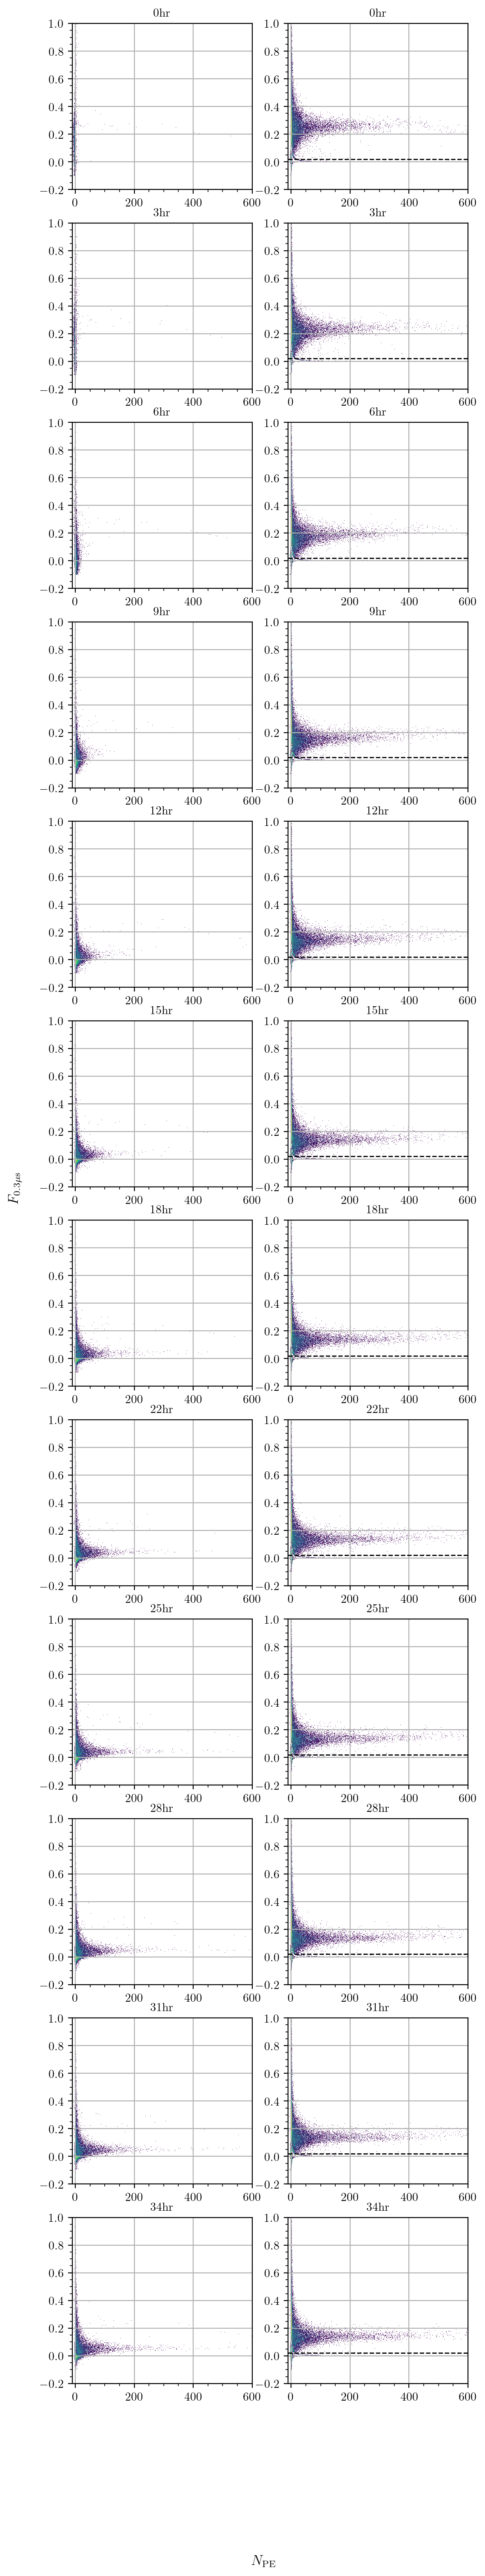

In [27]:
# Fprompt plots for all datasets
fig, axs = plt.subplots(len(files[:12]), len(positions), sharex=False, sharey=False)
fig.tight_layout(h_pad=5, w_pad=3)
fig.set_size_inches(6, 3*len(files[:12]))
for i in range(len(files[:12])):
    for j, (p,g) in enumerate(zip(positions,groups)):
        axs[i,j].pcolormesh(*fprompt[i][g])
        if p=='nofs':
            axs[i,j].plot([-10,range_maxx],[fp_thre[g]]*2,'k--',linewidth=1)
        axs[i,j].set_xlim(-10, range_maxx)
        axs[i,j].minorticks_on()
        axs[i,j].grid()
        axs[i,j].set_title(f'{hr_from_inject[i]:.0f}hr')
fig.supylabel(r'$F_{\rm 0.3\mu s}$', x=0)
fig.supxlabel(r'$N_{\rm PE}$',y=0.05)

(0.0, 0.4)

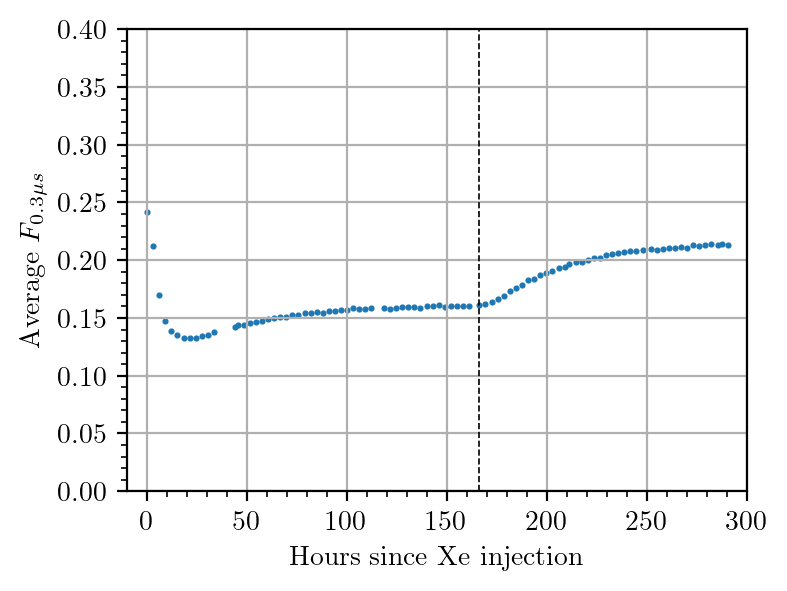

In [28]:
fp_avg = []
for i in range(len(data)):
    fp_avg.append(data[i]['fprompt_0p30us_1247'][(data[i]['pe_1247']>10) & (data[i]['pe_1247']<600)].mean())
plt.scatter(hr_from_inject,fp_avg,s=1.5)
plt.plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,[0,0.4],'k--',linewidth=0.6)
plt.xlabel('Hours since Xe injection')
plt.ylabel(r'Average $F_{0.3\mu s}$')
plt.grid()
plt.minorticks_on()
plt.xlim(-10,300)
plt.ylim(0,0.4)

In [29]:
nbinsx = 500
range_minx = -50
range_maxx = 1000
nbinsy = 500
range_miny = -50
range_maxy = 500

fs_nofs_pe = {}
for i in range(len(files)):
    fs_nofs_pe[i] = {}
    bsl_filt = data[i]['bsl_filt']
    fs_nofs_pe[i]['counts'], fs_nofs_pe[i]['xbins'], fs_nofs_pe[i]['ybins'] = np.histogram2d(
        data[i]['nofs_pe'][bsl_filt & data[i]['fp_filt_1247']], 
        data[i]['fs_pe'][bsl_filt & data[i]['fp_filt_1247']], 
        bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]]
    )
    fs_nofs_pe[i]['counts'] = fs_nofs_pe[i]['counts'].T
    fs_nofs_pe[i]['xbins'], fs_nofs_pe[i]['ybins'] = np.meshgrid(
        fs_nofs_pe[i]['xbins'], fs_nofs_pe[i]['ybins']
    )

Text(-0.03, 0.5, '$N_{\\rm PE}$ Fused Silica')

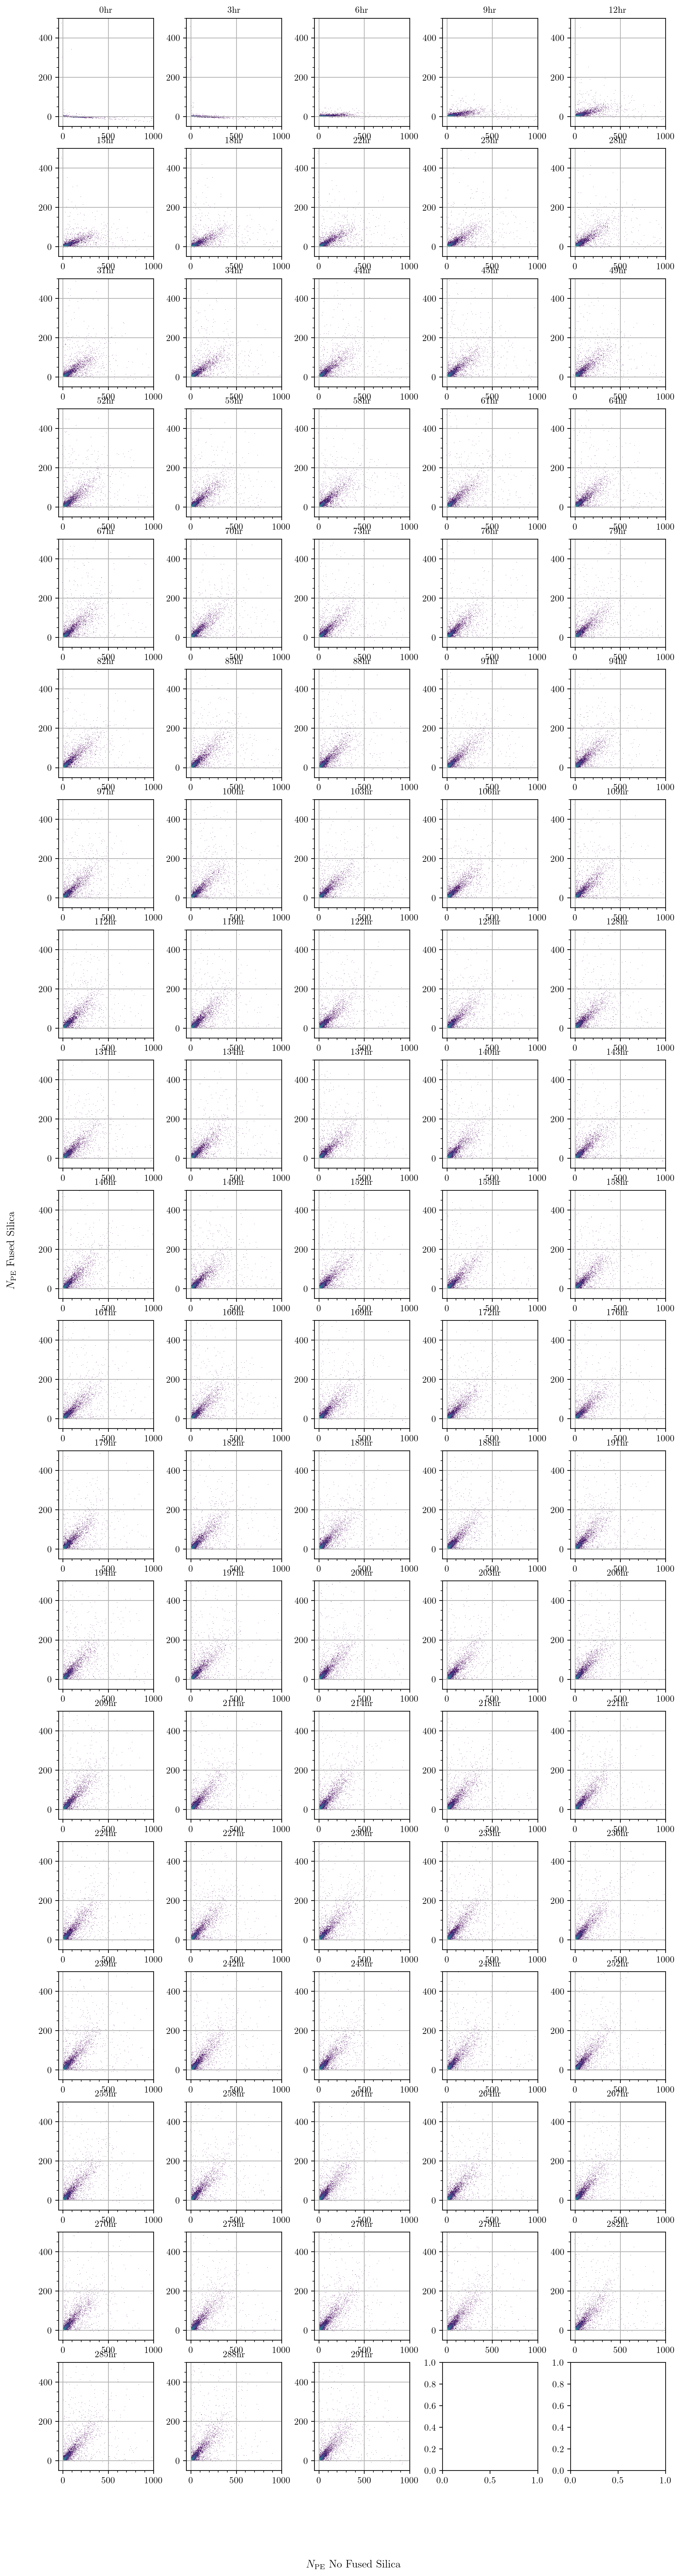

In [30]:
nrows = (len(data)+4)//5
fig, axs = plt.subplots(nrows, 5, sharex=False, sharey=False)
fig.set_size_inches(10, 2*nrows)
fig.tight_layout(h_pad=0.5, w_pad=0.5)
for i, c in enumerate(hr_from_inject):
    axs[i//5, i%5].pcolormesh(
        fs_nofs_pe[i]['xbins'],
        fs_nofs_pe[i]['ybins'],
        np.log10(fs_nofs_pe[i]['counts'])
    )
    axs[i//5, i%5].minorticks_on()
    axs[i//5, i%5].grid()
    axs[i//5, i%5].set_title(f'{c:.0f}hr')
    axs[i//5, i%5].set_xlim(-50, 1000)
    axs[i//5, i%5].set_ylim(-50, 500)
fig.supxlabel(r'$N_{\rm PE}$ No Fused Silica',y=-0.03)
fig.supylabel(r'$N_{\rm PE}$ Fused Silica',x=-0.03)

In [31]:
# Initialize container
spectra = []
window = ['yes', 'no']
for i in range(len(data)):
    spectra.append({})
    for w in window:
        spectra[i][w] = {}

In [32]:
# Region above norm_bounds is background only. Use event count in this region to normalize spectrum.
for i in range(len(data)):
    for w in window:
        if w=='yes':
            range_min = -10
            range_max = 2000
            nbins = 4000
        elif w=='no':
            range_min = -10
            range_max = 2000
            nbins = 4000
        bsl_filt = data[i]['bsl_filt']
        spectra[i][w]['counts'], spectra[i][w]['bins'] = np.histogram(
            data[i]['nofs_pe'][bsl_filt & data[i]['fp_filt_1247']] if w=='no' else data[i]['fs_pe'][bsl_filt & data[i]['fp_filt_1247']], 
            bins=nbins, range=(range_min, range_max)
        )
        spectra[i][w]['errs'] = np.sqrt(spectra[i][w]['counts'])

Text(0.06, 0.5, 'Events')

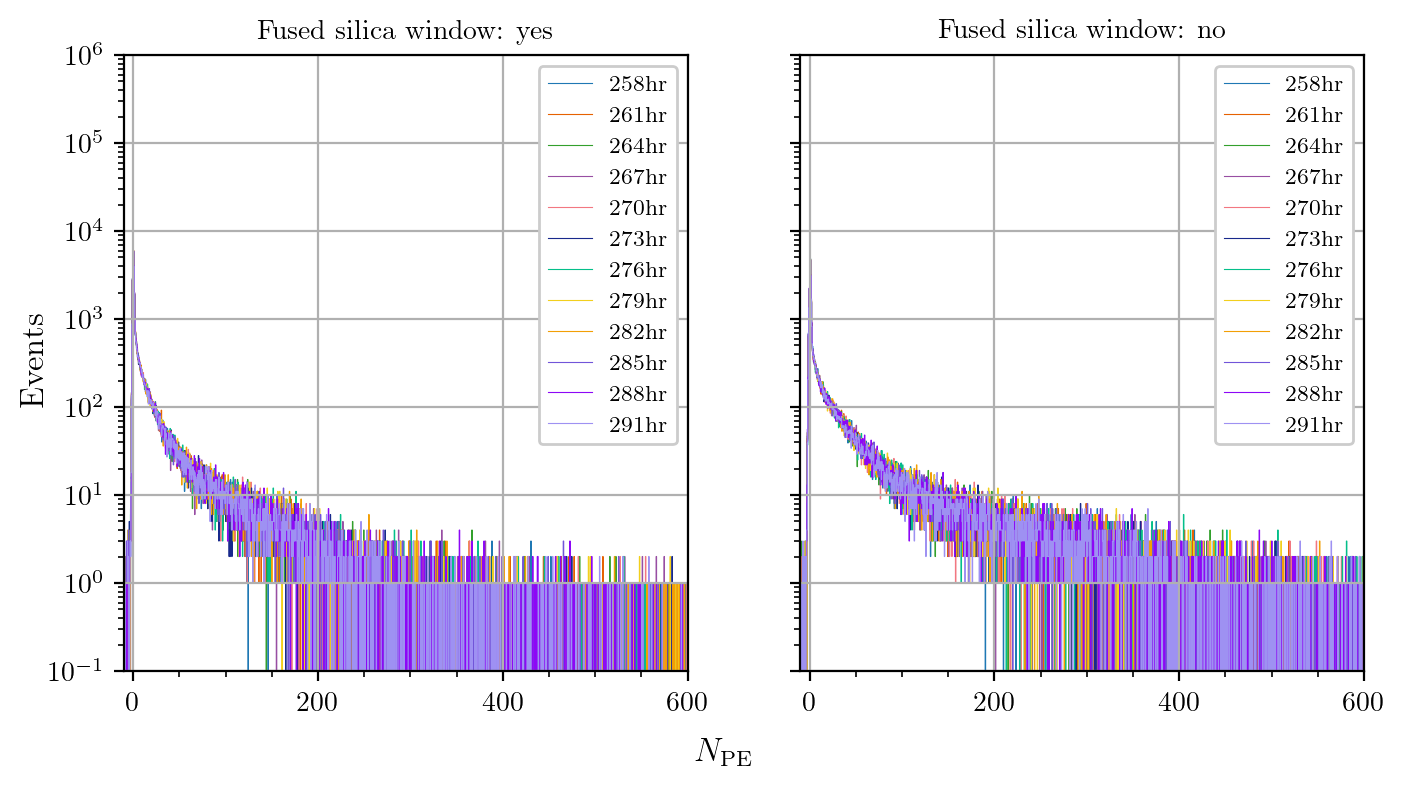

In [33]:
# Make plots for all datasets
# With source, without source, and background subtracted
fig, axs = plt.subplots(1, 2, sharex=False, sharey=True)
fig.set_size_inches(8, 4)
for j, w in enumerate(window):
    for i, c in enumerate(hr_from_inject[-12:]):
        axs[j].stairs(
            spectra[-12+i][w]['counts'], 
            spectra[-12+i][w]['bins'], 
            label=f'{c:.0f}hr', color=f'C{i}', linewidth=0.4
        )
    axs[j].legend(loc='upper right')
    axs[j].set_ylim(1e-1, 1e6)
    axs[j].set_xlim(-10, 600)
    axs[j].set_yscale('log')
    axs[j].minorticks_on()
    axs[j].grid()
    axs[j].set_title(f'Fused silica window: {w}')
fig.supxlabel(r'$N_{\rm PE}$', y=-0.01)
fig.supylabel('Events', x=0.06)

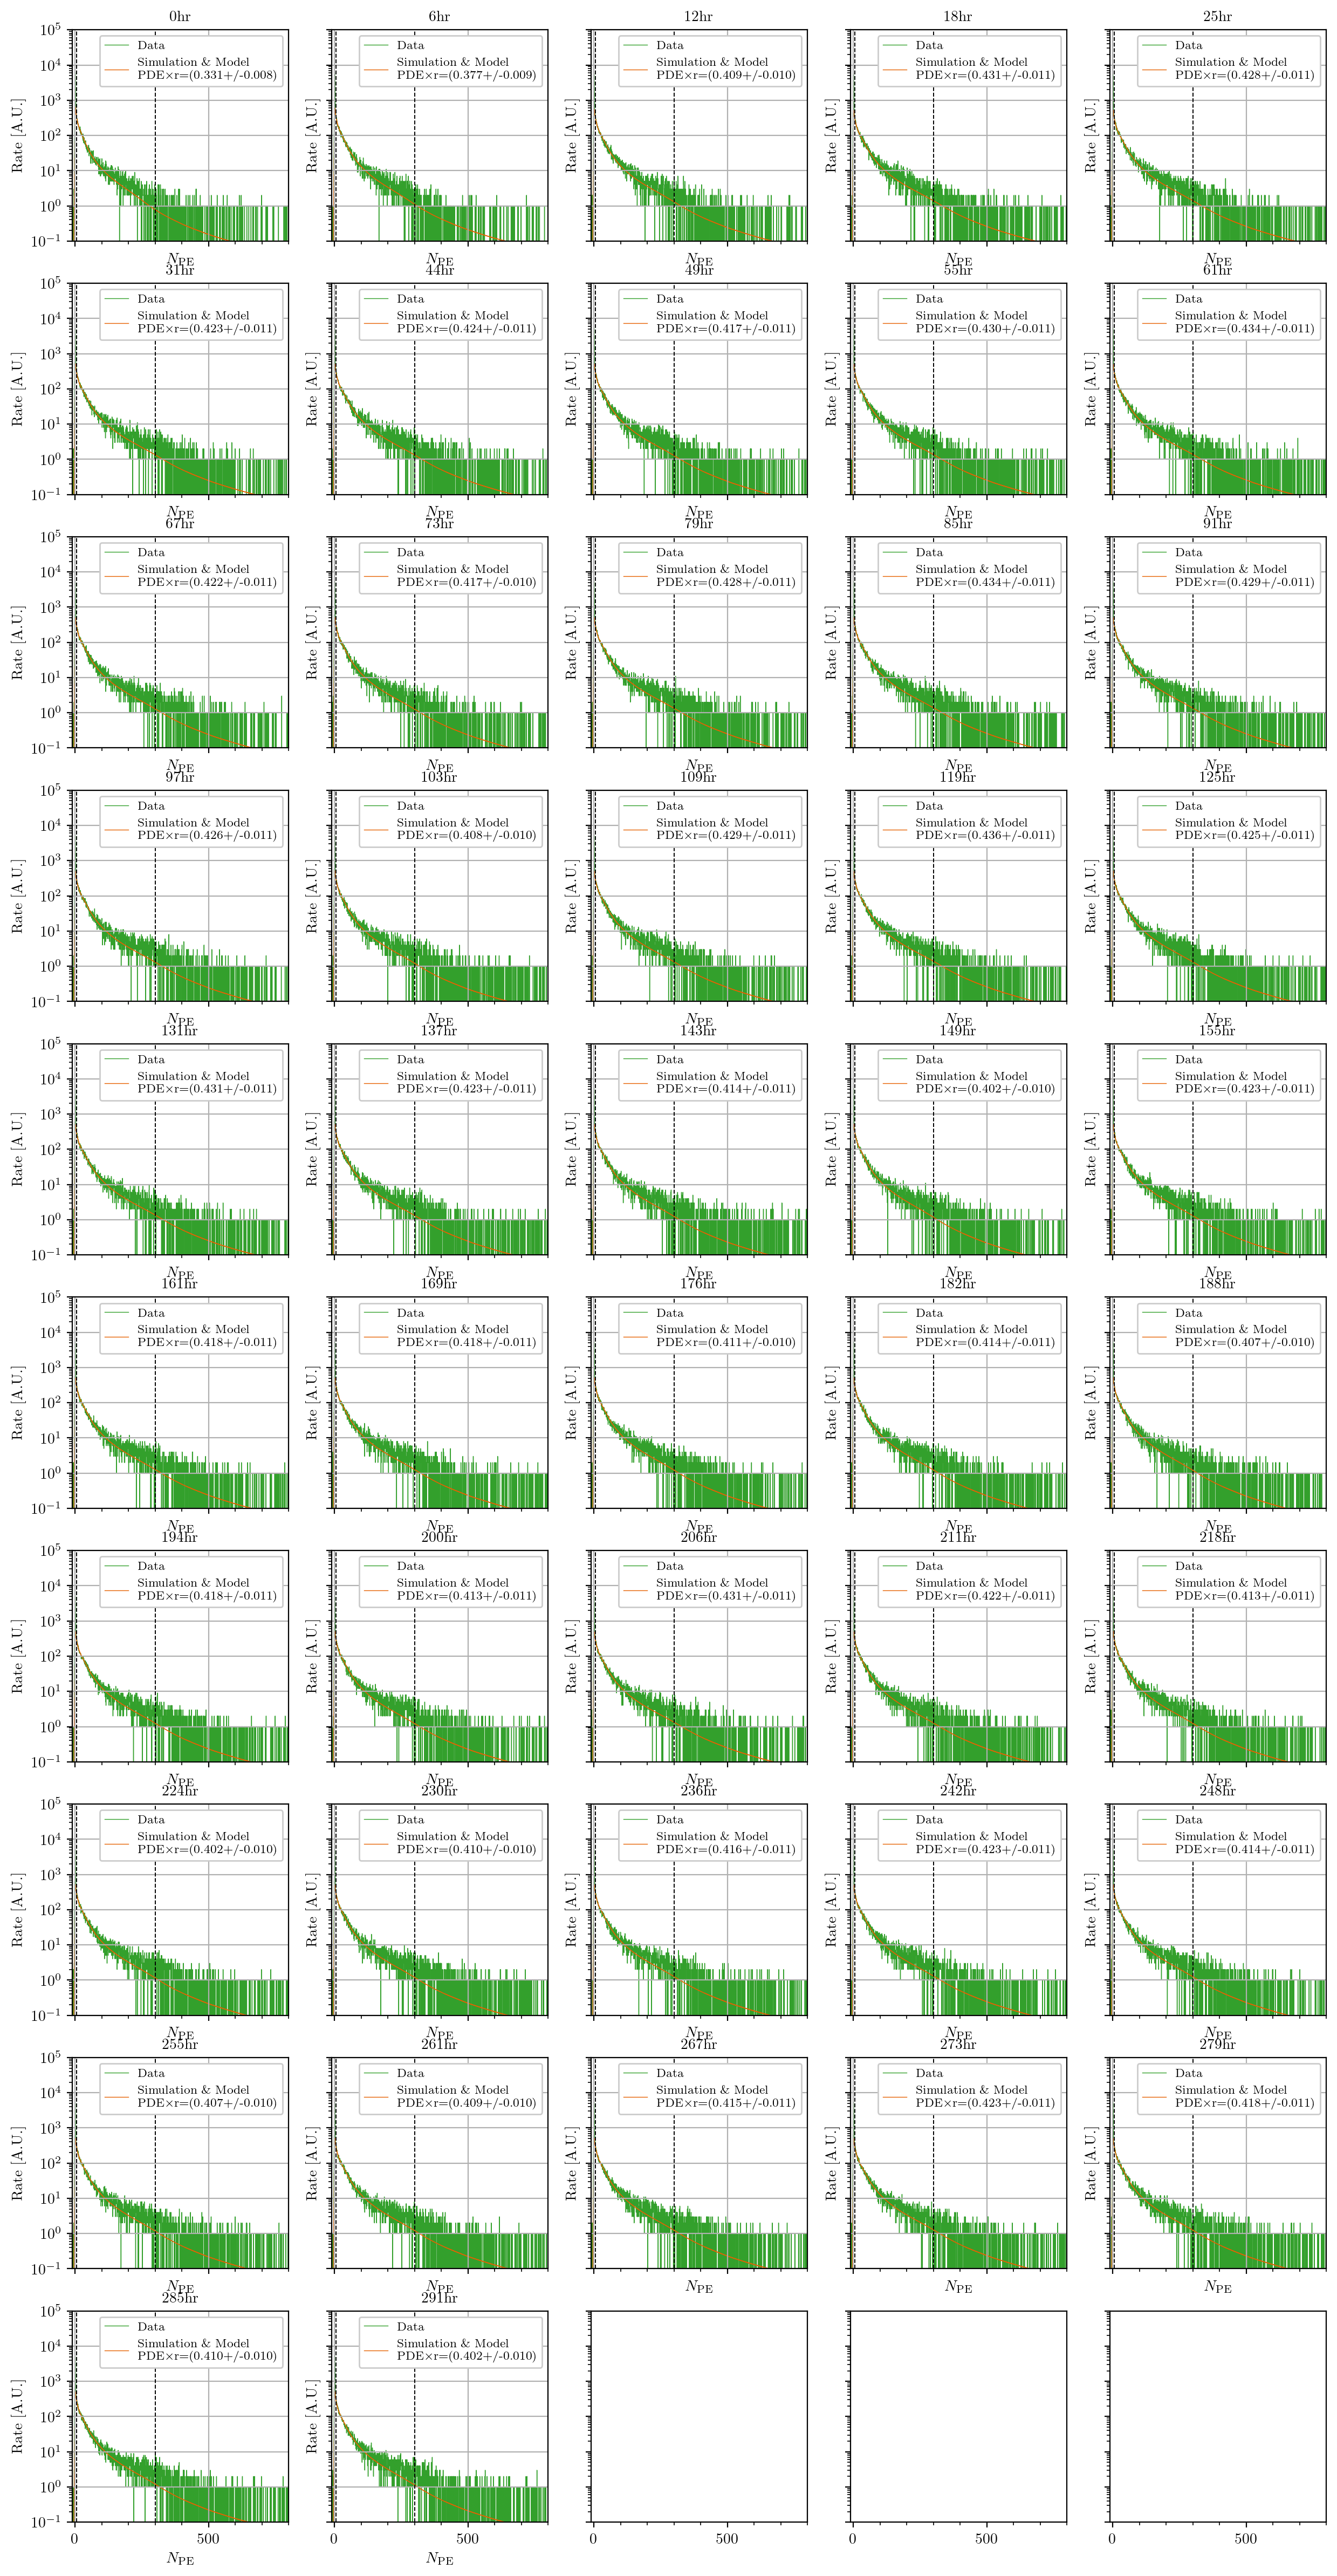

In [35]:
nrows = (len(data[::2])+4)//5
fig, axs = plt.subplots(nrows, 5, sharex=True, sharey=True)
fig.set_size_inches(15, 3*nrows)
pde_r_nofs = []
pde_r_nofs_err = []
hrs = []
for i in range(len(data[::2])):
    fit_range = (5,300)
    ymin, ymax = 1e-1,1e8
    smear = DetectorSmearing(fano=np.mean(calib[98]['fano'][[1,2,4,7]]),hist_in=hist_sim['Co-60'])
    par,cov = smear.fit_to_data(
        data=(spectra[i*2]['no']['counts'],spectra[i*2]['no']['bins']),
        sigma=spectra[i*2]['no']['errs'],
        x0=[4e4,0.3*4/5],
        fit_range=fit_range
    )
    par_err = np.array([func.error_distance(df=2, sigma=1)*cov[j,j]**0.5 for j in range(len(par))])
    axs[i//5, i%5].stairs(spectra[i*2]['no']['counts'],spectra[i*2]['no']['bins'], label='Data', color='C2', linewidth=0.5)
    axs[i//5, i%5].stairs(*(smear.get_spectrum(spectra[i*2]['no']['bins'],*par)), label='Simulation \& Model\n'+r'PDE$\times$r='+f'({par[1]:.3f}+/-{par_err[1]:.3f})', color='C1', linewidth=0.5)
    axs[i//5, i%5].plot([fit_range[0]]*2,[ymin,ymax],'k--',linewidth=0.7)
    axs[i//5, i%5].plot([fit_range[1]]*2,[ymin,ymax],'k--',linewidth=0.7)
    axs[i//5, i%5].set_yscale('log')
    axs[i//5, i%5].minorticks_on()
    axs[i//5, i%5].grid()
    axs[i//5, i%5].set_ylim(1e-1,1e5)
    axs[i//5, i%5].set_xlim(-10,800)
    axs[i//5, i%5].legend(loc='upper right')
    axs[i//5, i%5].set_title(f'{hr_from_inject[i*2]:.0f}hr')
    axs[i//5, i%5].set_xlabel(r'$N_{\rm PE}$')
    axs[i//5, i%5].set_ylabel(r'Rate [A.U.]')
    pde_r_nofs.append(par[1])
    pde_r_nofs_err.append(par_err[1])

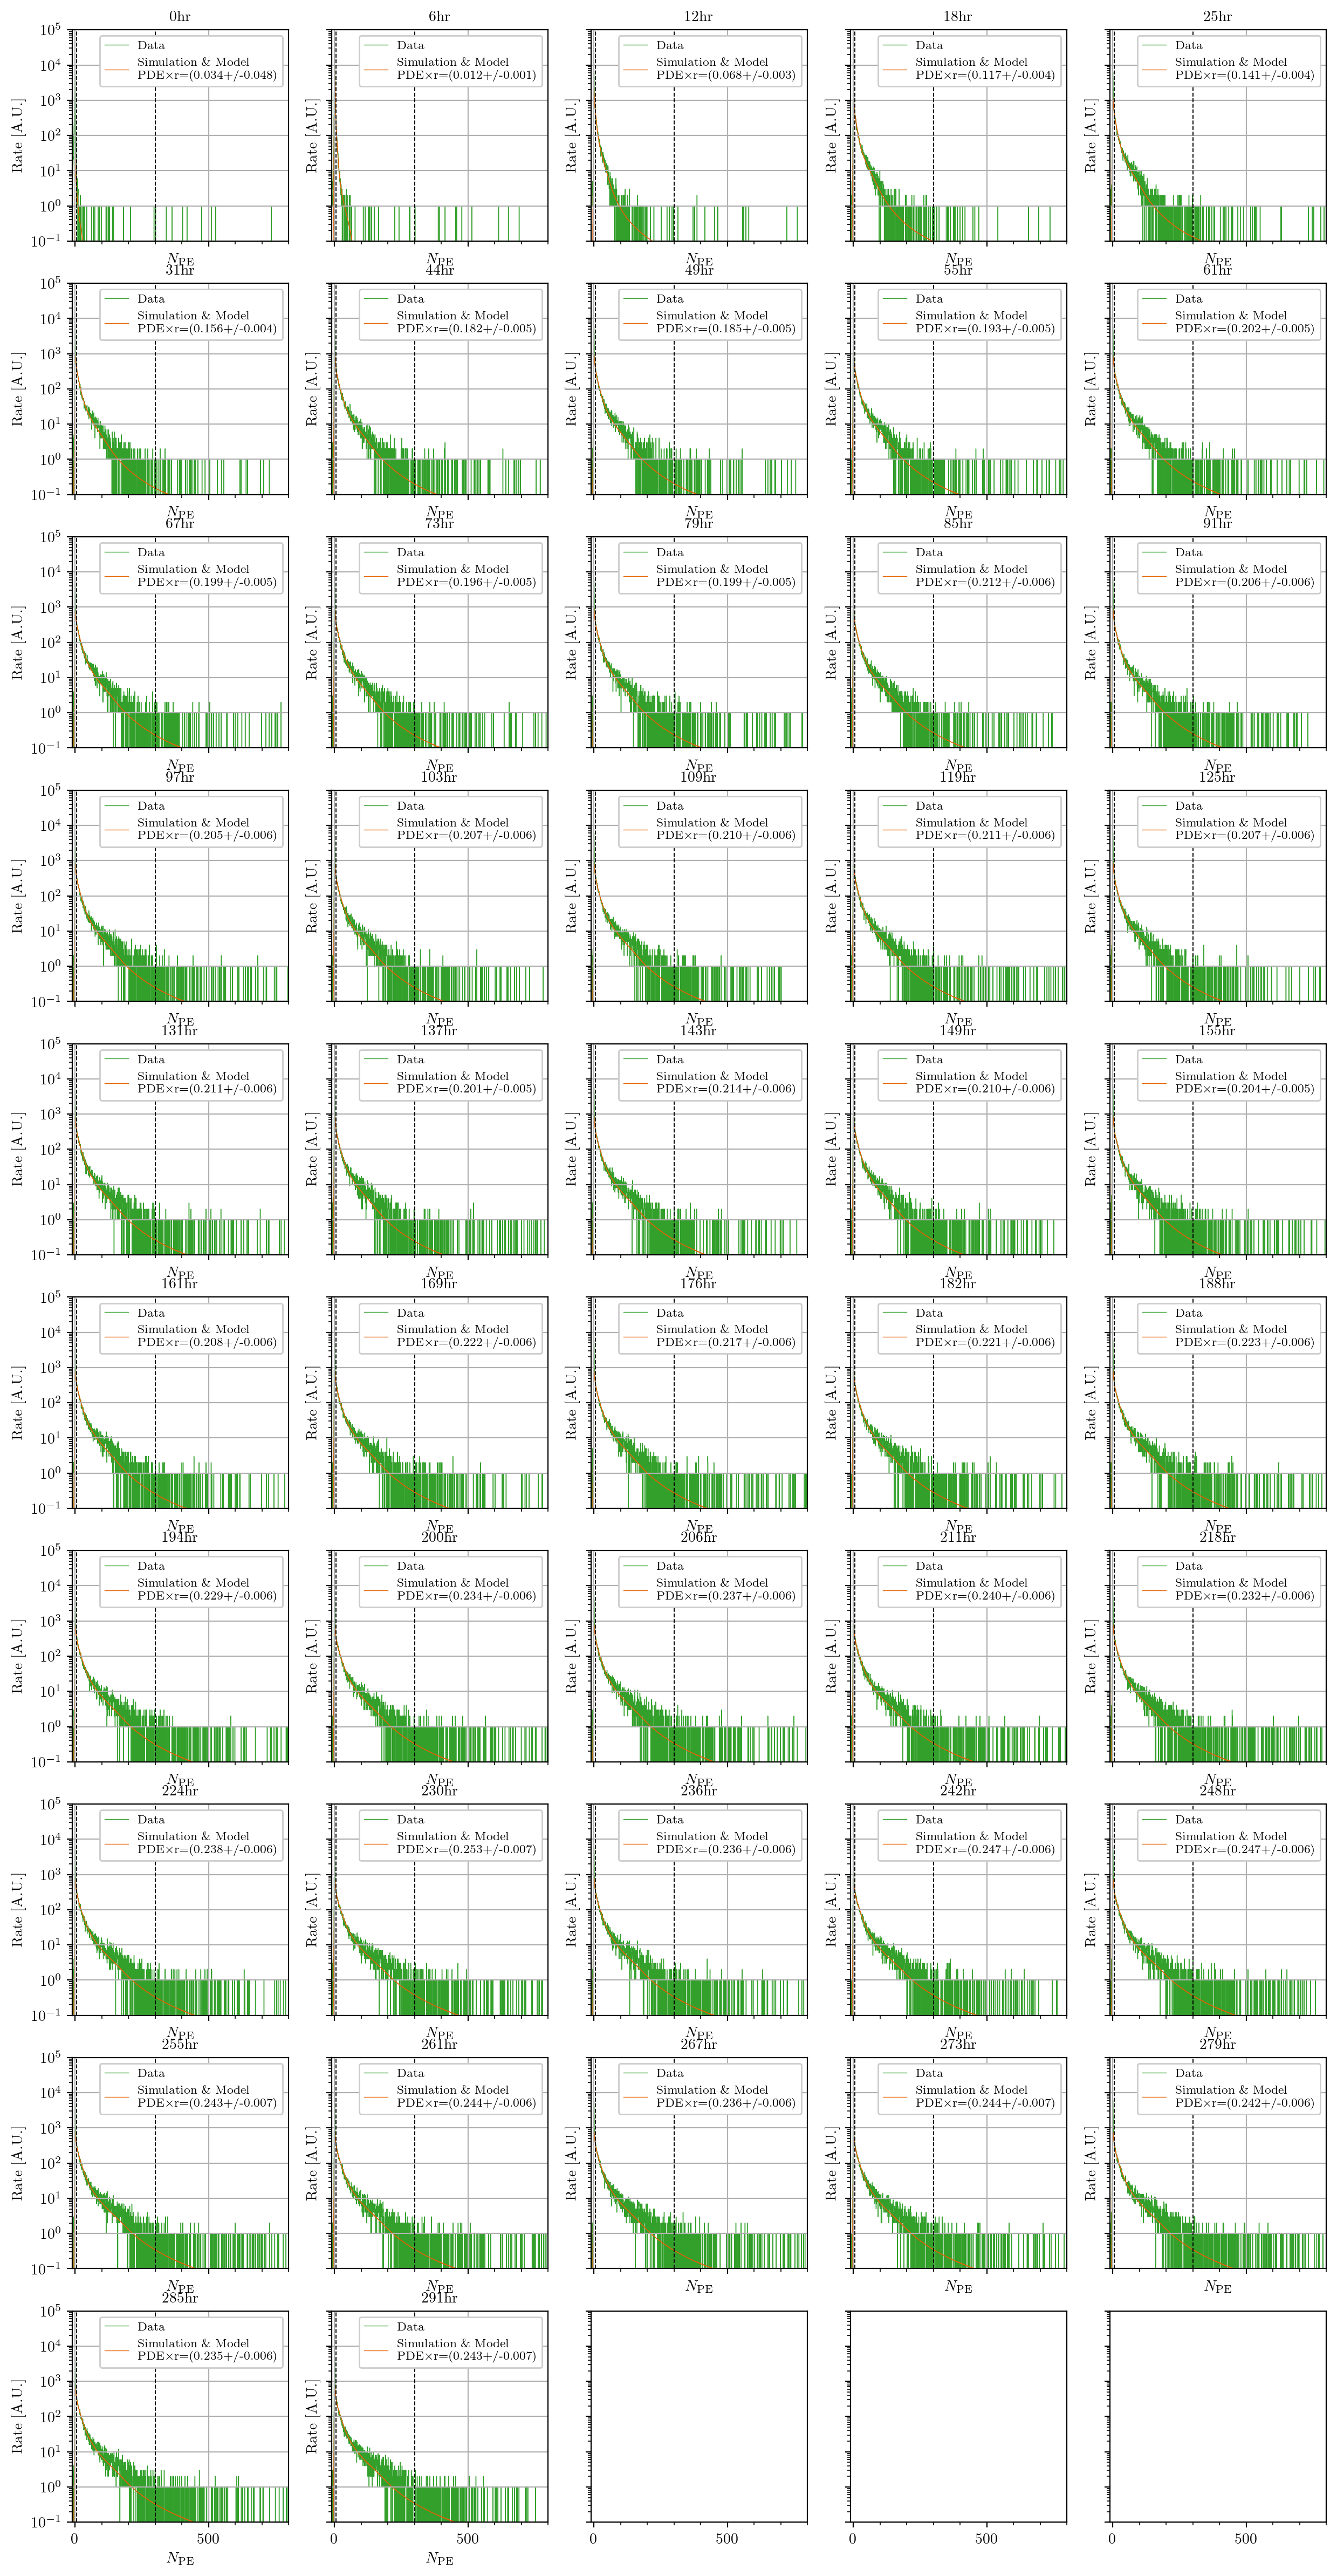

In [36]:
nrows = (len(data[::2])+4)//5
fig, axs = plt.subplots(nrows, 5, sharex=True, sharey=True)
fig.set_size_inches(15, 3*nrows)
pde_r_fs = []
pde_r_fs_err = []
for i in range(len(data[::2])):
    fit_range = (5,300)
    ymin, ymax = 1e-1,1e8
    smear = DetectorSmearing(fano=np.mean(calib[98]['fano'][[0,3,5,6]]),hist_in=hist_sim['Co-60'])
    par,cov = smear.fit_to_data(
        data=(spectra[i*2]['yes']['counts'],spectra[i*2]['yes']['bins']),
        sigma=spectra[i*2]['yes']['errs'],
        x0=[4e4,0.1*4/5],
        fit_range=fit_range
    )
    par_err = np.array([func.error_distance(df=2, sigma=1)*cov[j,j]**0.5 for j in range(len(par))])
    axs[i//5, i%5].stairs(spectra[i*2]['yes']['counts'],spectra[i*2]['yes']['bins'], label='Data', color='C2', linewidth=0.5)
    axs[i//5, i%5].stairs(*(smear.get_spectrum(spectra[i*2]['yes']['bins'],*par)), label='Simulation \& Model\n'+r'PDE$\times$r='+f'({par[1]:.3f}+/-{par_err[1]:.3f})', color='C1', linewidth=0.5)
    axs[i//5, i%5].plot([fit_range[0]]*2,[ymin,ymax],'k--',linewidth=0.7)
    axs[i//5, i%5].plot([fit_range[1]]*2,[ymin,ymax],'k--',linewidth=0.7)
    axs[i//5, i%5].set_yscale('log')
    axs[i//5, i%5].minorticks_on()
    axs[i//5, i%5].grid()
    axs[i//5, i%5].set_ylim(1e-1,1e5)
    axs[i//5, i%5].set_xlim(-10,800)
    axs[i//5, i%5].legend(loc='upper right')
    axs[i//5, i%5].set_title(f'{hr_from_inject[i*2]:.0f}hr')
    axs[i//5, i%5].set_xlabel(r'$N_{\rm PE}$')
    axs[i//5, i%5].set_ylabel(r'Rate [A.U.]')
    pde_r_fs.append(par[1])
    pde_r_fs_err.append(par_err[1])

(0.0, 2.0)

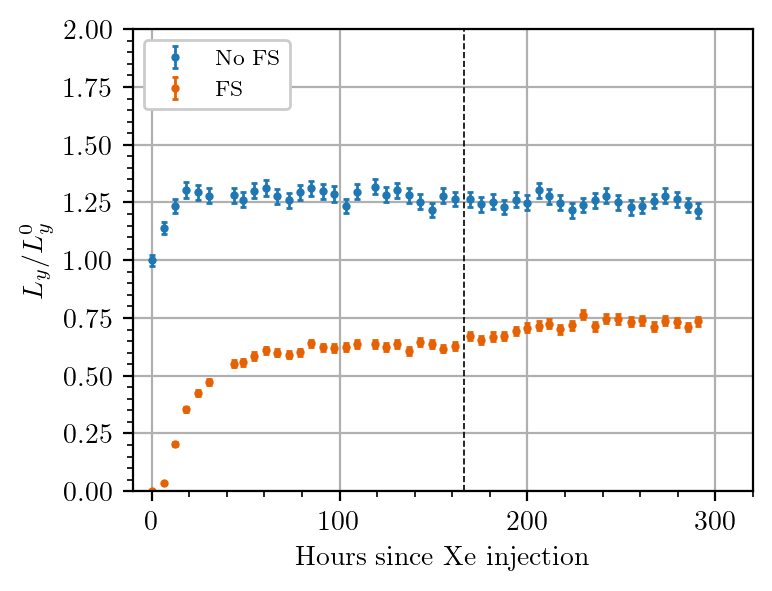

In [38]:
lyr_nofs = np.array(pde_r_nofs)/pde_r_nofs[0]
lyr_nofs_err = np.array(pde_r_nofs_err)/pde_r_nofs[0]
lyr_fs = np.array(pde_r_fs)/pde_r_nofs[0]
lyr_fs_err = np.array(pde_r_fs_err)/pde_r_nofs[0]
lyr_fs[0] = 0
lyr_fs_err[0] = 0
plt.errorbar(
    hr_from_inject[::2],
    lyr_nofs,
    yerr=lyr_nofs_err,
    label=f'No FS', linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1)
plt.errorbar(
    hr_from_inject[::2],
    lyr_fs,
    yerr=lyr_fs_err,
    label=f'FS', linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1)
plt.plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,[0,2],'k--',linewidth=0.6)
plt.legend()
plt.minorticks_on()
plt.grid()
plt.ylabel(r'$L_y/L_y^0$')
plt.xlabel('Hours since Xe injection')
plt.xlim(-10,320)
plt.ylim(0,2)

(0.0, 2.0)

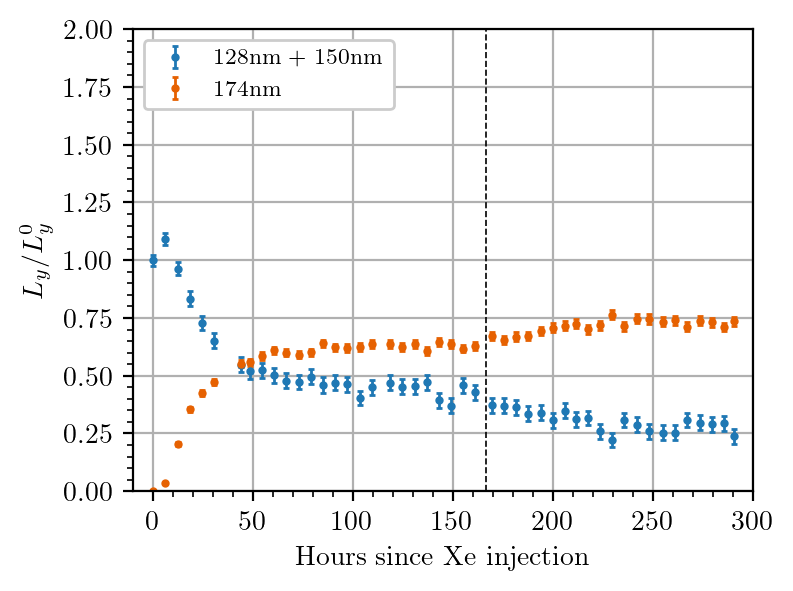

In [40]:
plt.errorbar(
    hr_from_inject[::2],
    lyr_nofs-1.33*lyr_fs,
    yerr=lyr_nofs_err,
    label=f'128nm + 150nm', linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1)
plt.errorbar(
    hr_from_inject[::2],
    lyr_fs,
    yerr=lyr_fs_err,
    label=f'174nm', linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1)
plt.plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,[0,2],'k--',linewidth=0.6)
plt.legend()
plt.minorticks_on()
plt.grid()
plt.ylabel(r'$L_y/L_y^0$')
plt.xlabel('Hours since Xe injection')
plt.xlim(-10,300)
plt.ylim(0,2)

(0.0, 2.0)

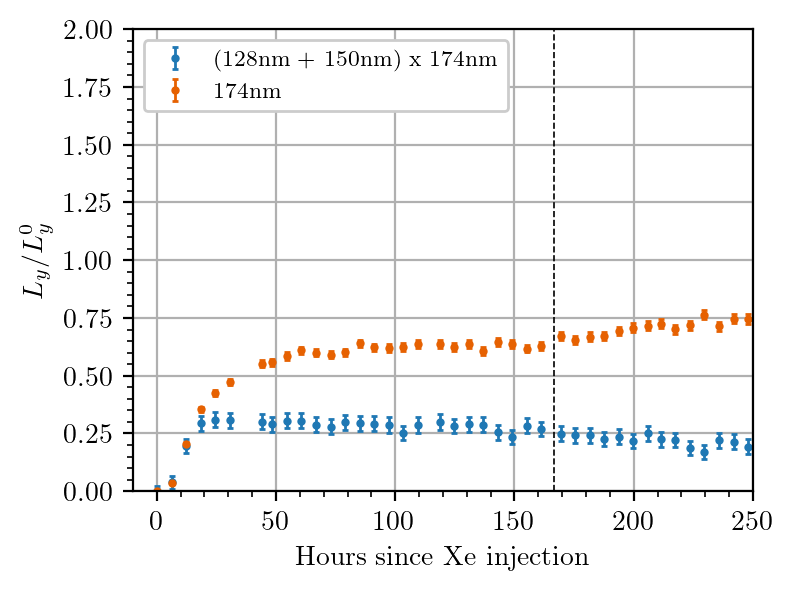

: 

In [42]:
plt.errorbar(
    hr_from_inject[::2],
    (lyr_nofs-1.33*lyr_fs)*lyr_fs,
    yerr=lyr_nofs_err,
    label=f'(128nm + 150nm) x 174nm', linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1)
plt.errorbar(
    hr_from_inject[::2],
    lyr_fs,
    yerr=lyr_fs_err,
    label=f'174nm', linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1)
plt.plot([(dt_xe2-dt_xe1).total_seconds()/S_PER_HR]*2,[0,2],'k--',linewidth=0.6)
plt.legend()
plt.minorticks_on()
plt.grid()
plt.ylabel(r'$L_y/L_y^0$')
plt.xlabel('Hours since Xe injection')
plt.xlim(-10,250)
plt.ylim(0,2)

# 3. Injection #1: Ba-133 Na-22 Light yield determination

In [55]:
path = "/scratch/gpfs/as111/results/"
src = ['Ba-133','Na-22']
xe_ppm = [0,2.7]
files = {'Ba-133':[glob(f"{path}2024-02-23/*source_ba133*scintillation_pulse_liq6.h5"),glob(f"{path}2024-03-06/*source_ba133*xenon_1*scintillation_pulse_liq6.h5")],
         'Na-22':[glob(f"{path}2024-02-23/*source_na22*scintillation_pulse_liq6.h5"),glob(f"{path}2024-03-06/*source_na22*xenon_1*scintillation_pulse_liq6.h5")]}
print(len(files['Ba-133'][0]), files['Ba-133'][0])
print(len(files['Ba-133'][1]), files['Ba-133'][1])
print(len(files['Na-22'][0]), files['Na-22'][0])
print(len(files['Na-22'][1]), files['Na-22'][1])


10 ['/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_ba133_run3_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_ba133_run1_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_ba133_run6_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_ba133_run5_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_ba133_run0_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_ba133_run2_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2024-02-23/2024-02-23_volt_98_light_scintillation_cond_gamma_source_ba133_run9_scintillation_pulse_liq6.h5', '/scratch/gpfs/as111/results/2

## Load h5

In [56]:
data = {}
channels = np.arange(-1,8)
volt = 98
for s in src:
    data[s] = []
    for i,x in enumerate(xe_ppm):
        df,_ = load_data(files[s][i],channels,volt)
        data[s].append(df)
        df = None
        print(f'{s} {x}ppm: {data[s][i].shape[0]} events')
print('columns: ', list(data[src[0]][0].columns))

Ba-133 0ppm: 503143 events
Ba-133 2.7ppm: 502914 events
Na-22 0ppm: 502997 events
Na-22 2.7ppm: 503555 events
columns:  ['start_datetime', 'end_datetime', 'duration_seconds', 'nch', 'nch_fs', 'nch_nofs', 'total_pe', 'fprompt_0p30us_01234567', 'fprompt_0p30us_0356', 'fprompt_0p30us_1247', 'baseline_mean_0', 'baseline_rms_0', 'integral_0p30us_0', 'integral_5p00us_0', 'fired_0', 'amplitude_0', 'peakpos_0', 'baseline_mean_1', 'baseline_rms_1', 'integral_0p30us_1', 'integral_5p00us_1', 'fired_1', 'amplitude_1', 'peakpos_1', 'baseline_mean_2', 'baseline_rms_2', 'integral_0p30us_2', 'integral_5p00us_2', 'fired_2', 'amplitude_2', 'peakpos_2', 'baseline_mean_3', 'baseline_rms_3', 'integral_0p30us_3', 'integral_5p00us_3', 'fired_3', 'amplitude_3', 'peakpos_3', 'baseline_mean_4', 'baseline_rms_4', 'integral_0p30us_4', 'integral_5p00us_4', 'fired_4', 'amplitude_4', 'peakpos_4', 'baseline_mean_5', 'baseline_rms_5', 'integral_0p30us_5', 'integral_5p00us_5', 'fired_5', 'amplitude_5', 'peakpos_5', 'ba

## Get PE

In [57]:
channels_nofs = [1,2,4,7]
channels_fs = [0,3,5,6]
volt = 98
for s in src:
    for i, x in enumerate(xe_ppm):
        df_nofs, df_fs = convert_to_pe(data[s][i],pe_scale[volt],channels_nofs), convert_to_pe(data[s][i],pe_scale[volt],channels_fs)
        data[s][i][df_nofs.name] = df_nofs
        df_nofs = None
        data[s][i][df_fs.name] = df_fs
        df_fs = None
        data[s][i]['pe_01234567'] = data[s][i]['total_pe']
        data[s][i]['fs_pe'] = data[s][i]['pe_0356']
        data[s][i]['nofs_pe'] = data[s][i]['pe_1247']
print('columns: ', list(data[src[0]][0].columns))

columns:  ['start_datetime', 'end_datetime', 'duration_seconds', 'nch', 'nch_fs', 'nch_nofs', 'total_pe', 'fprompt_0p30us_01234567', 'fprompt_0p30us_0356', 'fprompt_0p30us_1247', 'baseline_mean_0', 'baseline_rms_0', 'integral_0p30us_0', 'integral_5p00us_0', 'fired_0', 'amplitude_0', 'peakpos_0', 'baseline_mean_1', 'baseline_rms_1', 'integral_0p30us_1', 'integral_5p00us_1', 'fired_1', 'amplitude_1', 'peakpos_1', 'baseline_mean_2', 'baseline_rms_2', 'integral_0p30us_2', 'integral_5p00us_2', 'fired_2', 'amplitude_2', 'peakpos_2', 'baseline_mean_3', 'baseline_rms_3', 'integral_0p30us_3', 'integral_5p00us_3', 'fired_3', 'amplitude_3', 'peakpos_3', 'baseline_mean_4', 'baseline_rms_4', 'integral_0p30us_4', 'integral_5p00us_4', 'fired_4', 'amplitude_4', 'peakpos_4', 'baseline_mean_5', 'baseline_rms_5', 'integral_0p30us_5', 'integral_5p00us_5', 'fired_5', 'amplitude_5', 'peakpos_5', 'baseline_mean_6', 'baseline_rms_6', 'integral_0p30us_6', 'integral_5p00us_6', 'fired_6', 'amplitude_6', 'peakpos

## Apply RMS cut

In [58]:
rms_threshold = [2.0,2.0,2.0,2.0,2.3,2.0,2.0,2.0]
for s in src:
    for i, x in enumerate(xe_ppm):
        df_bsl_filt = get_bsl_filt(data[s][i],np.arange(8),rms_threshold)
        data[s][i][df_bsl_filt.columns] = df_bsl_filt
        df_bsl_filt = None

## Apply Fprompt cut

In [59]:
# Initialize container
fprompt = {}
positions = ['all','fs','nofs']
groups = ['01234567','0356','1247']
fp_thre = {'01234567':0.05,'0356':0.1,'1247':0.05}

In [60]:
# Produce fprompt 2D histograms
binsx = 500
range_minx = -10
range_maxx = 600
binsy = 500
range_miny = 0
range_maxy = 1

for s in src:
    fprompt[s] = []
    for i, x in enumerate(xe_ppm):
        fprompt[s].append(get_fp_hist2d(data[s][i],groups,'0p30us',bins_xy=[binsx,binsy],range_xy=[[range_minx,range_maxx],[range_miny,range_maxy]],log_scale=True))
        df_fp_filt = get_fp_filt(data[s][i],groups,fp_thre,'0p30us')
        data[s][i][df_fp_filt.columns] = df_fp_filt
        df_fp_filt = None

# Generate Npe spectra

In [61]:
spectra = {}
window = ['yes', 'no']
for s in src:
    spectra[s] = {}
    for i,x in enumerate(xe_ppm):
        spectra[s][i] = {}
        for w in window:
            spectra[s][i][w] = {}
            range_min = -10
            range_max = 2000
            nbins = 4000
             
            bsl_filt = data[s][i]['bsl_filt']
            spectra[s][i][w]['counts'], spectra[s][i][w]['bins'] = np.histogram(
                data[s][i]['nofs_pe'][bsl_filt & data[s][i]['fp_filt_01234567']] if w=='no' else data[s][i]['fs_pe'][bsl_filt & data[s][i]['fp_filt_01234567']], 
                bins=nbins, range=(range_min, range_max)
            )
            spectra[s][i][w]['errs'] = np.sqrt(spectra[s][i][w]['counts'])

Text(0.08, 0.5, 'Events')

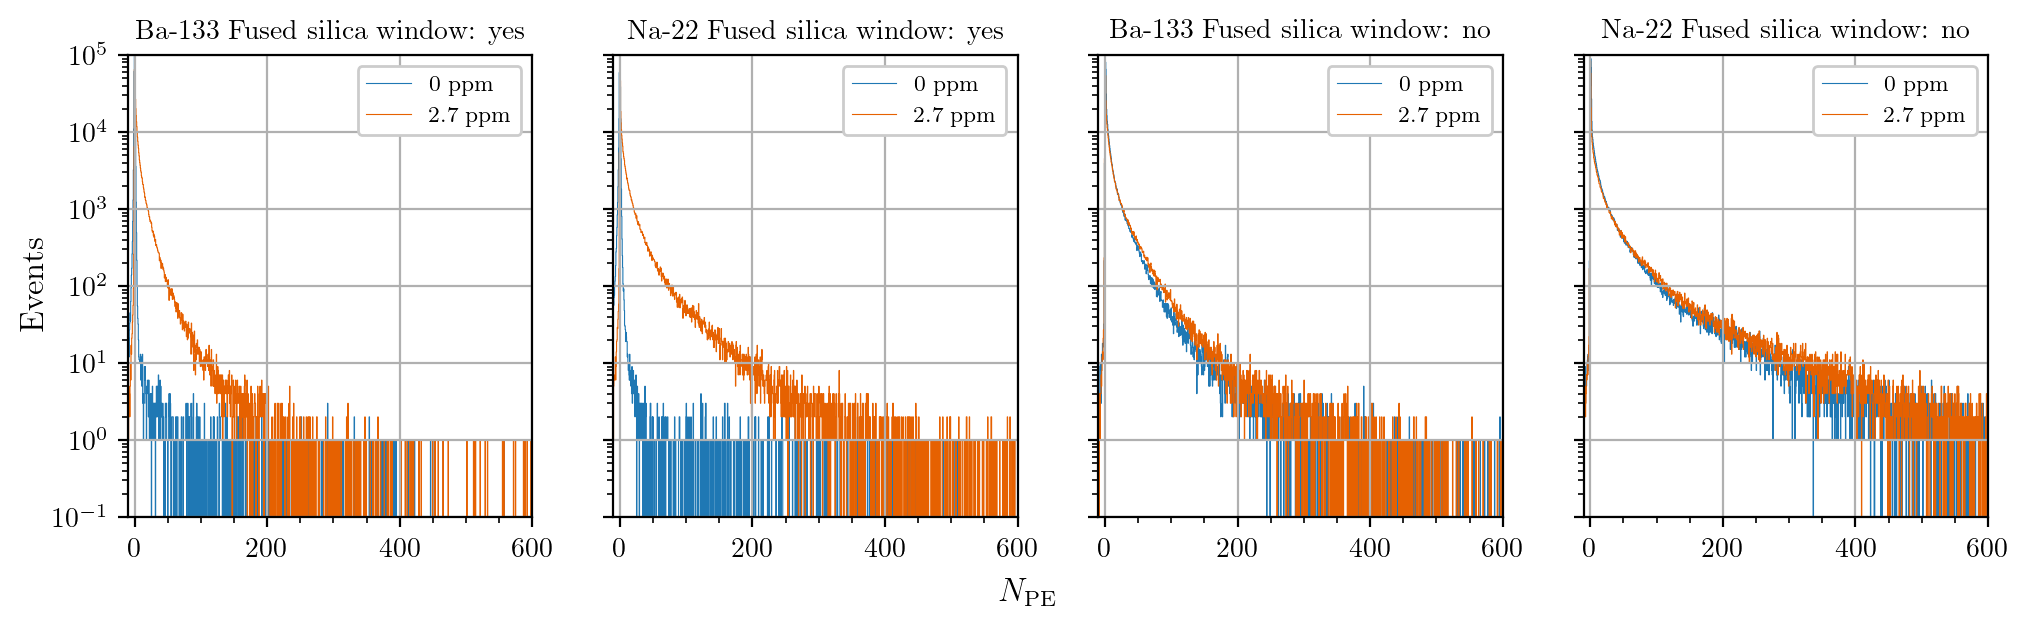

In [62]:
fig, axs = plt.subplots(1, 4, sharex=False, sharey=True)
fig.set_size_inches(12, 3)
for i,w in enumerate(window):
    for j,s in enumerate(src):
        for k,x in enumerate(xe_ppm):
            axs[i*2+j].stairs(
                spectra[s][k][w]['counts'], 
                spectra[s][k][w]['bins'], 
                label=f'{x} ppm', color=f'C{k}', linewidth=0.4
            )
        axs[i*2+j].legend(loc='upper right')
        axs[i*2+j].set_ylim(1e-1, 1e5)
        axs[i*2+j].set_xlim(-10, 600)
        axs[i*2+j].set_yscale('log')
        axs[i*2+j].minorticks_on()
        axs[i*2+j].grid()
        axs[i*2+j].set_title(f'{s} Fused silica window: {w}')
fig.supxlabel(r'$N_{\rm PE}$', y=-0.04)
fig.supylabel('Events', x=0.08)

# Spectrum Fitting

Text(-0.04, 0.5, 'Rate [A.U.]')

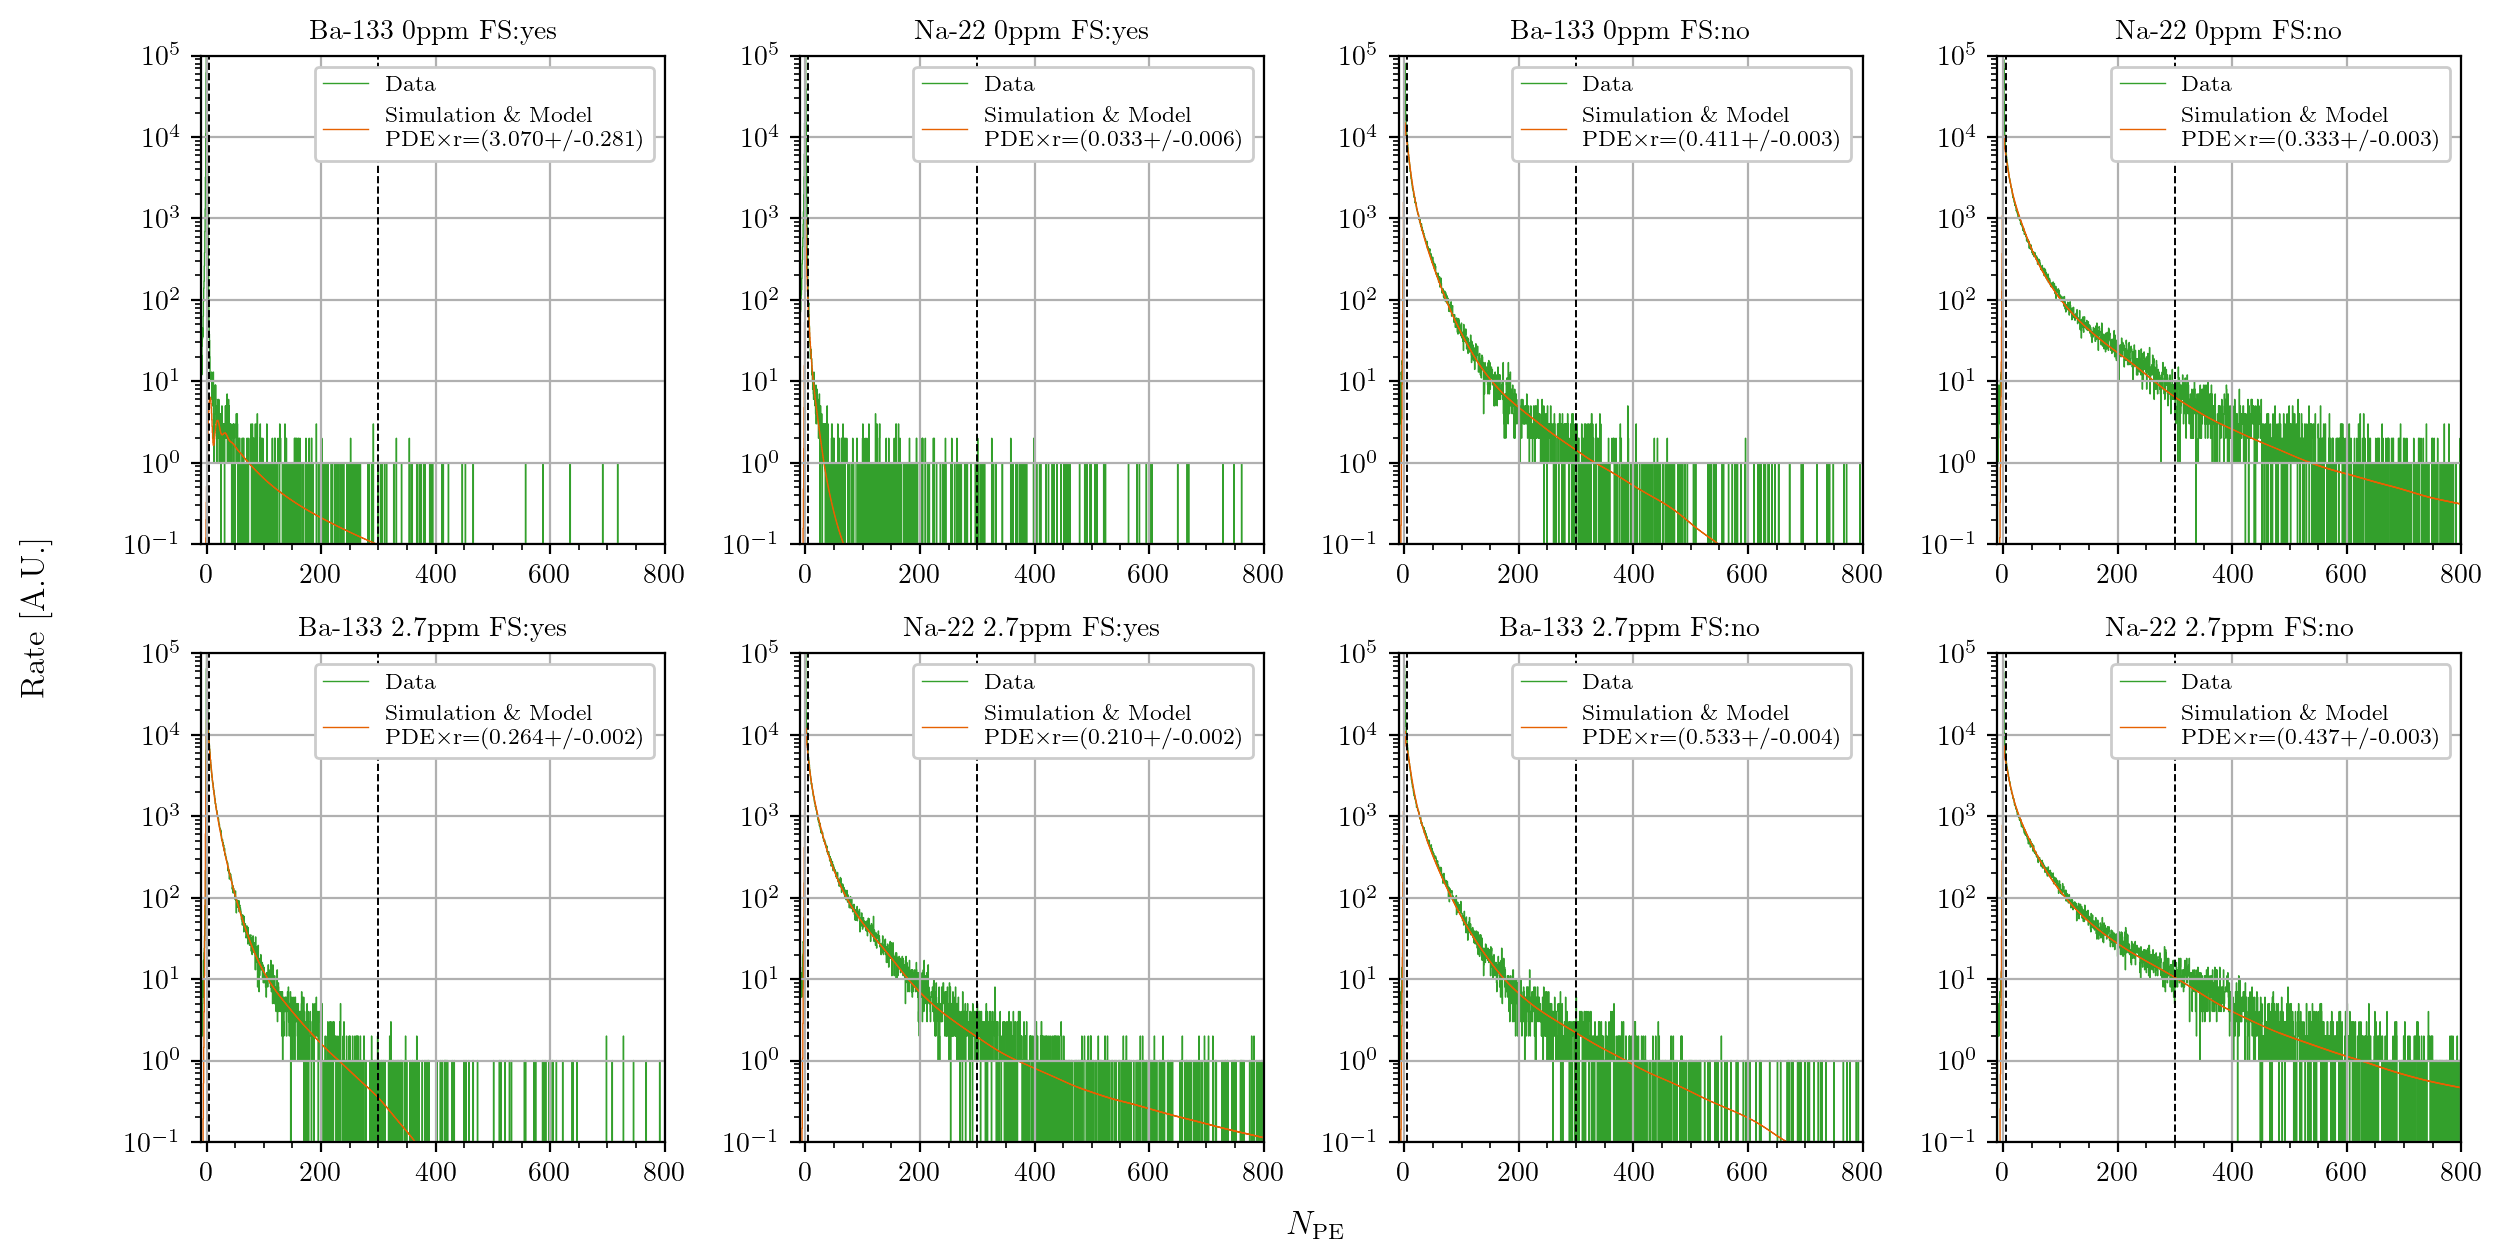

In [63]:
# Ba-133
ly, ly_err = {}, {}
fig, axs = plt.subplots(len(xe_ppm), 4, sharex=False, sharey=False)
fig.set_size_inches(12, 3*len(xe_ppm))
fig.tight_layout(h_pad=2, w_pad=2)
for i,w in enumerate(window):
    ly[w] = {}
    ly_err[w] = {}
    for j,s in enumerate(src):
        ly[w][s] = []
        ly_err[w][s] = []
        for k,x in enumerate(xe_ppm):
            fit_range = (5,300)
            ymin, ymax = 1e-1,1e8
            smear = DetectorSmearing(
                fano=np.mean(calib[98]['fano'][[0,3,5,6]]) if w=='yes' else np.mean(calib[98]['fano'][[1,2,4,7]]),
                hist_in=hist_sim[s]
            )
            par,cov = smear.fit_to_data(
                data=(spectra[s][k][w]['counts'],spectra[s][k][w]['bins']),
                sigma=spectra[s][k][w]['errs'],
                x0=[5e5,0.4] if w=='no' else [5e5,0.1],
                fit_range=fit_range
            )
            par_err = np.array([func.error_distance(df=2, sigma=1)*cov[j,j]**0.5 for j in range(len(par))])
            axs[k,i*2+j].stairs(spectra[s][k][w]['counts'],spectra[s][k][w]['bins'], label='Data', color='C2', linewidth=0.5)
            axs[k,i*2+j].stairs(*(smear.get_spectrum(spectra[s][k][w]['bins'],*par)), label='Simulation \& Model\n'+r'PDE$\times$r='+f'({par[1]:.3f}+/-{par_err[1]:.3f})', color='C1', linewidth=0.5)
            axs[k,i*2+j].plot([fit_range[0]]*2,[ymin,ymax],'k--',linewidth=0.7)
            axs[k,i*2+j].plot([fit_range[1]]*2,[ymin,ymax],'k--',linewidth=0.7)
            axs[k,i*2+j].set_yscale('log')
            axs[k,i*2+j].minorticks_on()
            axs[k,i*2+j].grid()
            axs[k,i*2+j].set_ylim(1e-1,1e5)
            axs[k,i*2+j].set_xlim(-10,800)
            axs[k,i*2+j].legend(loc='upper right')
            axs[k,i*2+j].set_title(f'{s} {x}ppm FS:{w}')
            ly[w][s].append(par[1])
            ly_err[w][s].append(par_err[1])
fig.supxlabel(r'$N_{\rm PE}$',y=-0.02)
fig.supylabel(r'Rate [A.U.]',x=-0.04)

In [77]:
hr_from_inject[48]

155.1988888888889

(0.0, 2.0)

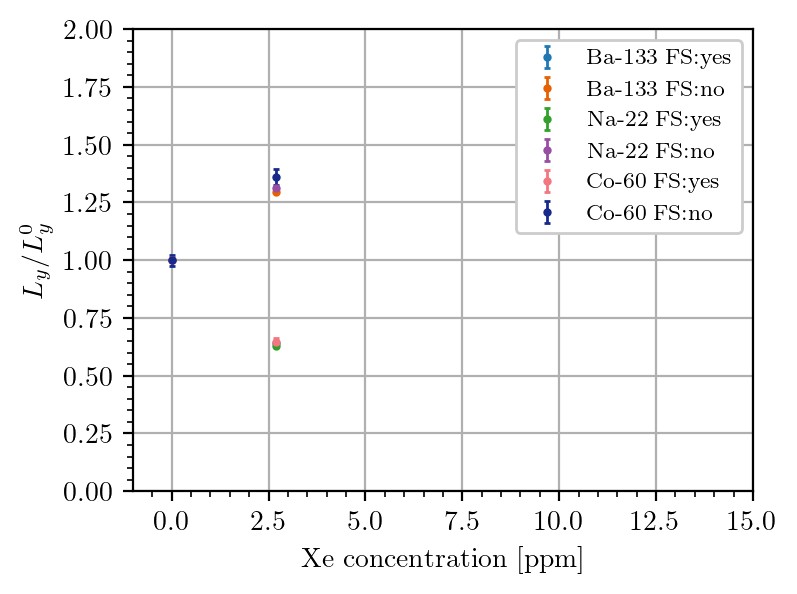

In [83]:
for i,w in enumerate(window):
    for j,s in enumerate(src):
        ly[w][s] = np.array(ly[w][s])/ly['no'][s][0]
        
plt.figure(0,figsize=(4,3))
for s in src:
    for w in window:
        plt.errorbar(
            xe_ppm if w=='no' else xe_ppm[1:],
            ly[w][s] if w=='no' else ly[w][s][1:],
            yerr=ly_err[w][s] if w=='no' else ly_err[w][s][1:],
            label=f'{s} FS:{w}', linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1)
plt.errorbar(
    xe_ppm[1:],
    np.array([pde_r_fs[16]])/pde_r_ref,
    yerr=np.array([pde_r_fs_err[16]])/pde_r_ref,
    label=f'Co-60 FS:yes', linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1)        
plt.errorbar(
    xe_ppm,
    pde_r_nofs[[0,16]]/pde_r_ref,
    yerr=pde_r_nofs_err[[0,16]]/pde_r_ref,
    label=f'Co-60 FS:no', linestyle='', linewidth=1, fmt='o', markersize=2, capsize=1)
plt.legend(loc='upper right')
plt.minorticks_on()
plt.grid()
plt.ylabel(r'$L_y/L_y^0$')
plt.xlabel('Xe concentration [ppm]')
plt.xlim(-1,15)
plt.ylim(0,2)